# Packages

In [1]:
import sys
# Appending python modules so we can run simulations
sys.path.append("../python")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import stimuli_generation
import os
from utility import load_scene
from pymunk.vec2d import Vec2d
import numpy as np
import json

pygame 2.1.2 (SDL 2.0.18, Python 3.9.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Plotting parameters

In [2]:
sns.set_palette("tab10")
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set(rc={'figure.figsize':(12,10)})

# Helper functions

In [3]:
def save_plot(df1, df2, df3, filename, responses, save=False):
    scene_type = filename.split('/')[-1]
    # Set figure object
    fig, axs = plt.subplots(1,4,figsize=(24,6),gridspec_kw={'width_ratios': [1,1.5,1.5,1.5]})
    # Title subplots
    axs[0].title.set_text("Runtime per cumulative distance traveled from origin to Goal")
    axs[1].title.set_text("Predicted RT for pure simulation")
    axs[2].title.set_text("Predicted RT for abstraction")
    axs[3].title.set_text("Empirical RT per Goal Position")
    # Set subplots
    g=sns.scatterplot(x="x", 
                      y="y", 
                      hue="runtime",
                      s=200,
                      data=df1,
                      palette="coolwarm",
                      edgecolor="none",
                      ax=axs[0])
    g.set(ylim=(0, 1000),xlim=(0,800))
    g.invert_yaxis()
    
    g=sns.scatterplot(x="distance_cumulative",
                      y="runtime",
                      hue="runtime",
                      s=200,
                      data=df2,
                      edgecolor="none",
                      palette="coolwarm",
                      ax=axs[1])
    g.set(ylim=(0, 400),xlim=(0,1200))
    
    g=sns.scatterplot(x="distance_cumulative",
                      y="runtime",
                      hue="runtime",
                      s=200,
                      data=df3,
                      edgecolor="none",
                      palette="tab10",
                      ax=axs[2])
    g.set(ylim=(0, 400),xlim=(0,1200))
    
    g = sns.lineplot(x='distance',
                      y='part_zrt',
                      data=responses.loc[(responses.scene_type == scene_type) & (responses.scene_col == "yes") & (responses.correct == True)],
                      hue='model_abs_rt',
                     marker='o', ci=95,
                      palette="tab10",
                      ax=axs[3])
    g.set(xlim=(0,1200))
    
    g = sns.lineplot(x='distance',
                      y='model_abs_rt',
                      data=responses.loc[(responses.scene_type == scene_type) & (responses.scene_col == "yes") & (responses.correct == True)],
                      hue='model_abs_rt',
                     marker='o', ci=95,
                      palette="tab10",
                      ax=axs[3])
    g.set(xlim=(0,1200))
    
    if save:
        plt.savefig(filename)
    else:
        plt.show()

# Importing and cleaning data

## Importing data

In [4]:
# Experiment 3
data_path_exp3 = "../experiments/experiment3/data/cleaned_data.json"
# Experiment 4
data_path_exp4 = "../experiments/experiment4/data/data.csv"
# Experiment 5
data_path_exp5 = "../experiments/experiment5/data/data.csv"
# Experiment 6
data_path_exp6 = "../experiments/experiment6/data/data.csv"

In [5]:
# Read in data
data_exp3 = pd.read_json(data_path_exp3)
data_exp4 = pd.read_csv(data_path_exp4)
data_exp5 = pd.read_csv(data_path_exp5)
data_exp6 = pd.read_csv(data_path_exp6)

In [6]:
data_exp3['experiment_version'] = 3
data_exp4['experiment_version'] = 4
data_exp5['experiment_version'] = 5
data_exp6['experiment_version'] = 6

In [21]:
data_exp456 = pd.read_json("./cleaned_data_exp_4_5_6.json")
data = pd.concat([data_exp3, data_exp456])

In [9]:
data = pd.concat([data_exp3,data_exp4,data_exp5,data_exp6],ignore_index=True)

In [22]:
data.groupby('experiment_version').subject_id.describe()


count unique                       top freq
experiment_version                                            
3                   2183     47  613ac4fcfa4b7e01abd45dc7   48
4                   5668     66  5f0559d1bc410b85707c58a3   89
5                   2923     34  60bf887f255c4637433ff78e   88
6                   2055     24  616606f0af139c90023c1a79   89

## Cleaning data

Here, we're removing unused columns that contain metadata from jsPsych. These are unnecessary for our analyses. 

In [11]:
# Removing unused columns from jsPsych
data = data.drop(columns=['success', 
                          'failed_images',
                          'failed_audio',
                          'failed_video',
                         'time_elapsed',
                         'scene_sp',
                         'internal_node_id',
                         'session_id',
                         'study_id',
                         'value',
                         'stimulus',
                         'timeout',
                         'trial_type'])

**Removing participants who failed comprehension:** Here, we're removing participants who could not get the comprehension questions right in three tries or less.

In [12]:
# List of subjects who failed comprehension check
failed_comprehension = []
# Iterate through all subjects
for subject in pd.unique(data.subject_id):
    # Find the number of attempts they made
    attempts = data.loc[(data.subject_id == subject) & (data.task == 'comprehension')].attempts.to_list()
    if max(attempts) > 3:
        failed_comprehension.append(subject)
print(f"{len(failed_comprehension)} of {len(pd.unique(data.subject_id))} ({15/42*100:.4}%) participants failed the comprehension check")

ValueError: max() arg is an empty sequence

In [10]:
# Remove people who failed comprehension check
data = data.loc[~(data.subject_id.isin(failed_comprehension))]

In [11]:
# Check that none of the remaining subjects also failed the comprehension check
l = pd.unique(data.subject_id)
all([x in failed_comprehension for x in l])

False

**Cleaning responses:** In line with good practice with dataframes, we are making a copy of our original dataframe `data` for analysis and calling it `responses`

In [12]:
# Copy dataframe
responses = data

In [13]:
# Remove attempts column since we no longer are using it
responses = responses.drop(columns=['attempts'])

**Cleaning scene types:** Our variable `scene_type` codes which scene type the participant is viewing (e.g. stim_2, stim_4, or stim_6). jsPsych records these data verbosely (e.g. "stim_2_goalpos_1_negative.mp4"). Here, we're cleaning up the `scene_type` entries so they just say what scene type the user viewed. For example, the entry "stim_2_goalpos_1_negative.mp4" will be changed to "stim_2".

In [14]:
# Convert all scene type entries to strings
responses.scene_type = responses.scene_type.astype(str)
# Retain only the scene type (remove "_goalpos_" substring)
responses.scene_type = responses.scene_type.apply(lambda x: "_".join(x.split('_')[:2]))

**Cleaning scenes:** The `scene` variable codes the actual scene the participant viewed (e.g. "stim_2_goalpos_1_negative.mp4"). We want to remove the ".mp4" substring from the entries in this variable.

In [15]:
# Convert all scene entries to strings
responses.scene = responses.scene.astype(str)
# Retain only the scene name (remove ".mp4" substring)
responses.scene = responses.scene.apply(lambda x: x.split('.')[0])

**Only viewing responses:** Since we removed the participants who failed the comprehension check, we are now only interested in the remaining participants' responses. So, we're removing the data that isn't coded as "response" in the `task` variable.

In [16]:
# Remove all tasks that aren't coded as response
responses = responses.loc[(responses.task == 'response')]

In [17]:
# Remove the task column since we no longer are using it
responses = responses.drop(columns=['task'])



**Compute z-scores:** We need to compute the z-scores of response times `rt`. We will do so participant-wise (per participant) and variable-wise (across the variable `rt`), and add them as new variables `part_zrt` and `var_zrt` respsectively.

In [18]:
# Calculate variable-wise z-scores for response time
responses['var_zrt'] = responses.groupby('experiment_version').rt.apply(lambda x: (x-x.mean()) / x.std())

In [19]:
# Calculate participant-wise z-score for response time
responses['part_zrt'] = responses.groupby(['experiment_version','subject_id']).rt.apply(lambda x: (x-x.mean()) / x.std())

In [20]:
# Check these z-scores are not equivalent
all(responses['var_zrt'] == responses['part_zrt'])
# sns.scatterplot(x="var_zrt",y="part_zrt", data=responses) # Should be a straight line if they're the same

False

**Removing outlier response times**: We can now remove outlier response times. We use the 2-SD methd as per Alexander Berger and Markus Kiefer, 2021. 2-SD outlier exclusion demonstrated best results for omitting Type-1 errors (false positives) and retaining original data.

In [21]:
# Determine number of datapoints lost by outlier exclusion
excluded = len(responses) - len(responses[abs(responses.part_zrt) <= 2])
print(f"{excluded} of {len(responses)} ({excluded/len(responses)*100:.4}%) are excluded via 2-SD exclusion")

514 of 11160 (4.606%) are excluded via 2-SD exclusion


In [22]:
# Excluding outliers
responses = responses[abs(responses.part_zrt) <= 2]

In [23]:
# Save file locally
responses.to_json("cleaned_data_exp_4_5_6.json")

# Analysis


## Normalized RT per `scene_type`

**Plotting average RT per scene type:** Here we're plotting the normalized RT `part_zrt` per scene type, partitioned by whether the scene contained a collision or not. Collision is coded by the binary `scene_col` variable.

<AxesSubplot:title={'center':'Experiment 6'}, xlabel='scene_type', ylabel='part_zrt'>

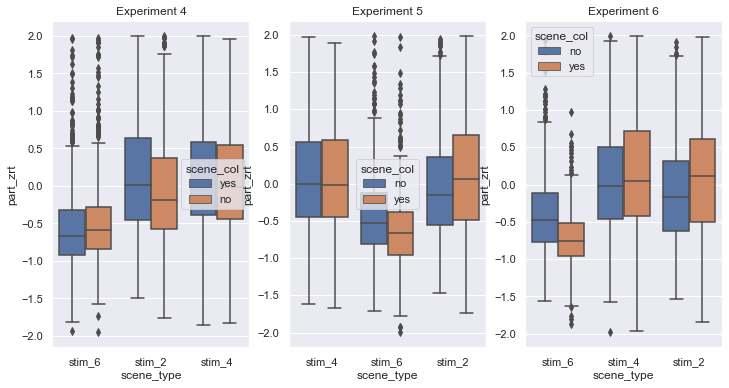

In [24]:
fig, axs = plt.subplots(1,3,figsize=(12,6))
axs[0].title.set_text("Experiment 4")
axs[1].title.set_text("Experiment 5")
axs[2].title.set_text("Experiment 6")
sns.boxplot(x="scene_type",y="part_zrt",hue="scene_col",data=responses.loc[responses.experiment_version==4],ax=axs[0])
sns.boxplot(x="scene_type",y="part_zrt",hue="scene_col",data=responses.loc[responses.experiment_version==5],ax=axs[1])
sns.boxplot(x="scene_type",y="part_zrt",hue="scene_col",data=responses.loc[responses.experiment_version==6],ax=axs[2])

## Normalized RT per `scene`

**Plotting participant z-RT per scene:** Here we're plotting the normalized RT `part_zrt` per `scene_index`, partitioned by `scene_type`. 

<AxesSubplot:title={'center':'RT Across Experiments 4 and 5'}, xlabel='scene_index', ylabel='part_zrt'>

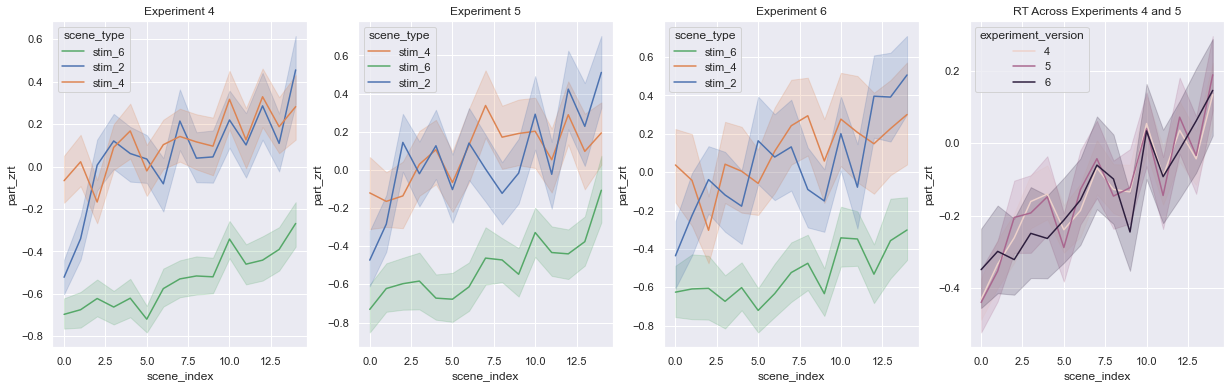

In [25]:
# Color palette to maintain consistency across plots
palette ={"stim_2": "C0", "stim_4": "C1", "stim_6": "C2"}

fig, axs = plt.subplots(1,4,figsize=(21,6))
axs[0].title.set_text("Experiment 4")
axs[1].title.set_text("Experiment 5")
axs[2].title.set_text("Experiment 6")
axs[3].title.set_text("RT Across Experiments 4 and 5")
sns.lineplot(x="scene_index",y="part_zrt",hue="scene_type",data=responses.loc[responses.experiment_version==4],ax=axs[0],palette=palette)
sns.lineplot(x="scene_index",y="part_zrt",hue="scene_type",data=responses.loc[responses.experiment_version==5],ax=axs[1],palette=palette)
sns.lineplot(x="scene_index",y="part_zrt",hue="scene_type",data=responses.loc[responses.experiment_version==6],ax=axs[2],palette=palette)
sns.lineplot(x="scene_index",y="part_zrt",hue="experiment_version",data=responses,ax=axs[3])

**Empirical RT distributions:** Here, we're investigating the spread and tendencies of RT distributions. 

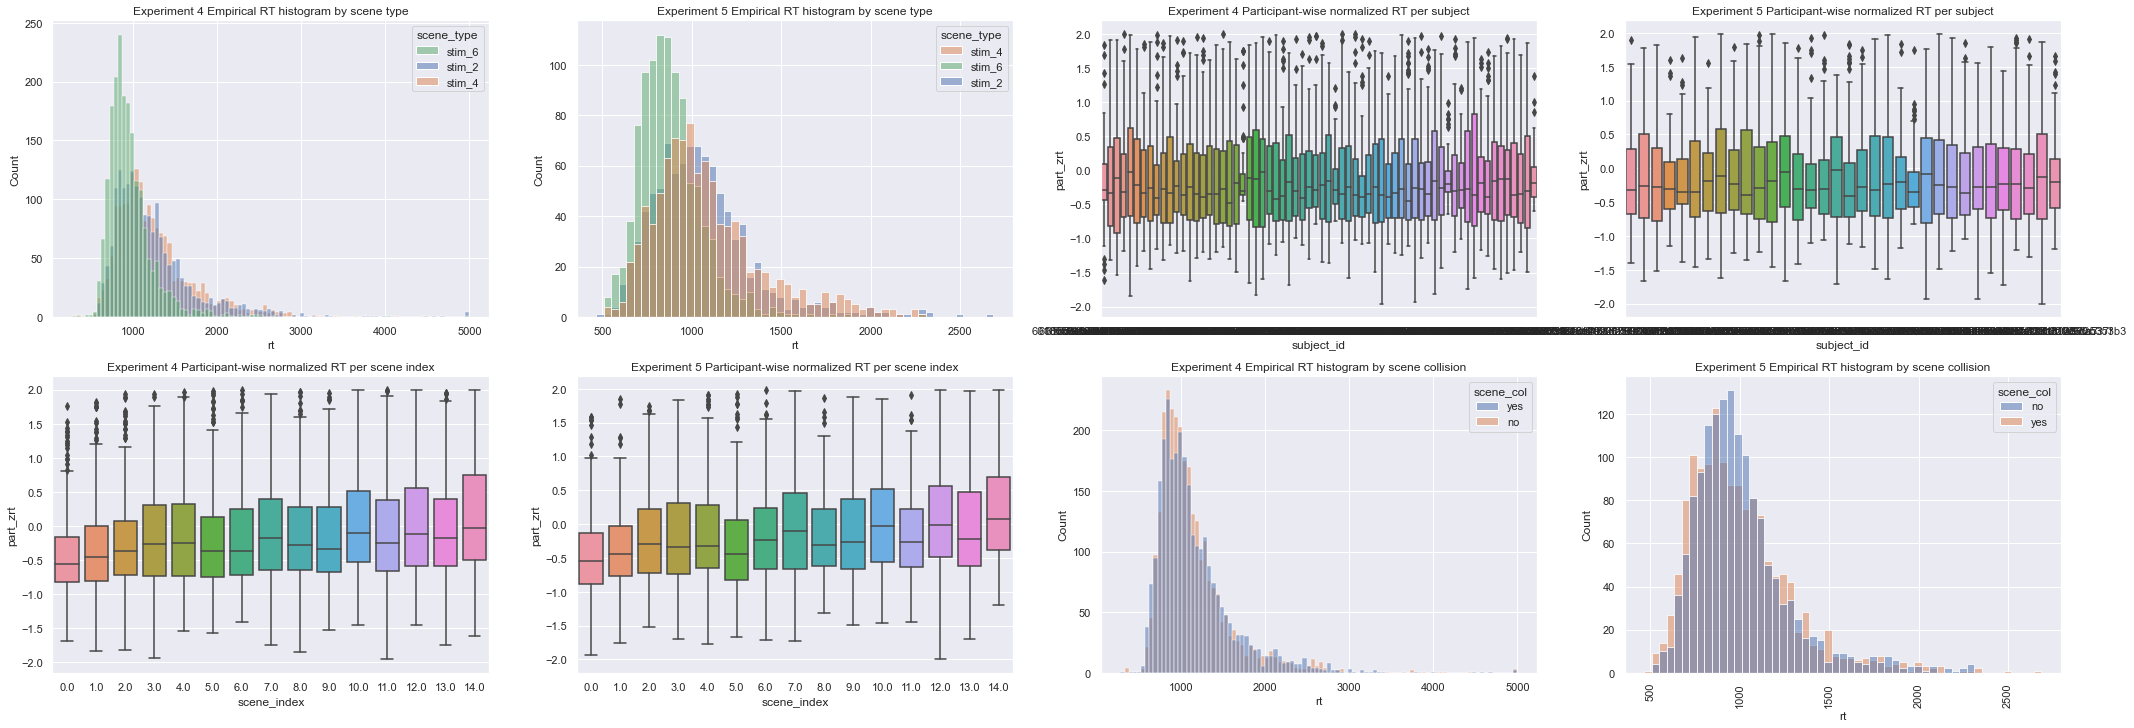

In [26]:
fig, axs = plt.subplots(2,4,figsize=(36,12))
# Title subplots
axs[0,0].title.set_text("Experiment 4 Empirical RT histogram by scene type")
axs[0,1].title.set_text("Experiment 5 Empirical RT histogram by scene type")
axs[0,2].title.set_text("Experiment 4 Participant-wise normalized RT per subject")
axs[0,3].title.set_text("Experiment 5 Participant-wise normalized RT per subject")

axs[1,0].title.set_text("Experiment 4 Participant-wise normalized RT per scene index")
axs[1,1].title.set_text("Experiment 5 Participant-wise normalized RT per scene index")
axs[1,2].title.set_text("Experiment 4 Empirical RT histogram by scene collision")
axs[1,3].title.set_text("Experiment 5 Empirical RT histogram by scene collision")

sns.histplot(x="rt",data=responses.loc[responses.experiment_version==4],hue='scene_type',ax=axs[0,0],palette=palette)
sns.histplot(x="rt",data=responses.loc[responses.experiment_version==5],hue='scene_type',ax=axs[0,1],palette=palette)
sns.boxplot(x='subject_id',y='part_zrt',data=responses.loc[responses.experiment_version==4],ax=axs[0,2])
sns.boxplot(x='subject_id',y='part_zrt',data=responses.loc[responses.experiment_version==5],ax=axs[0,3])
sns.boxplot(x='scene_index',y='part_zrt',data=responses.loc[responses.experiment_version==4],ax=axs[1,0])
sns.boxplot(x='scene_index',y='part_zrt',data=responses.loc[responses.experiment_version==5],ax=axs[1,1])
sns.histplot(x="rt",data=responses.loc[responses.experiment_version==4],hue='scene_col',ax=axs[1,2])
sns.histplot(x="rt",data=responses.loc[responses.experiment_version==5],hue='scene_col',ax=axs[1,3])
plt.xticks(rotation=90);

**Calculating scene accuracies:** Here we calculate the accuracy per scene.

In [27]:
responses['scene_accuracy'] = responses.groupby(['experiment_version','scene','scene_col']).correct.transform(lambda x: sum(x) / len(x))

In [28]:
responses['part_accuracy'] = responses.groupby(['experiment_version','subject_id']).correct.transform(lambda x: sum(x) / len(x))

In [29]:
responses['scene_index_accuracy'] = responses.groupby(['experiment_version','scene_index','scene_type']).correct.transform(lambda x: sum(x) / len(x))

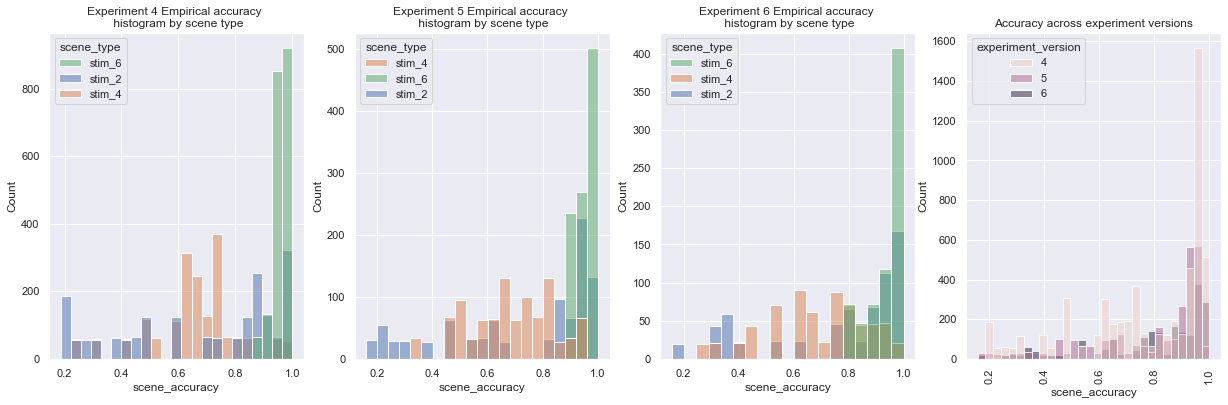

In [47]:
fig, axs = plt.subplots(1,4,figsize=(21,6))
# Title subplots
axs[0].title.set_text("Experiment 4 Empirical accuracy \n histogram by scene type")
axs[1].title.set_text("Experiment 5 Empirical accuracy \n histogram by scene type")
axs[2].title.set_text("Experiment 6 Empirical accuracy \n histogram by scene type")
axs[3].title.set_text("Accuracy across experiment versions")
sns.histplot(x="scene_accuracy",data=responses.loc[responses.experiment_version==4],ax=axs[0],hue="scene_type",palette=palette)
sns.histplot(x="scene_accuracy",data=responses.loc[responses.experiment_version==5],ax=axs[1],hue="scene_type",palette=palette)
sns.histplot(x="scene_accuracy",data=responses.loc[responses.experiment_version==6],ax=axs[2],hue="scene_type",palette=palette)
sns.histplot(x="scene_accuracy",data=responses,ax=axs[3],hue="experiment_version")
plt.xticks(rotation=90);

In [31]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

exp_4_scene_acc = list(responses.loc[responses.experiment_version==4].scene_accuracy)
exp_5_scene_acc = list(responses.loc[responses.experiment_version==5].scene_accuracy)

shap_exp4 = shapiro(exp_4_scene_acc)
shap_exp5 = shapiro(exp_5_scene_acc)

print(f"Shapiro Test Results:")
print(f"\tExperiment 4 data is: {'not' if shap_exp4.pvalue < 0.05 else ''} normal with p-val = {shap_exp4.pvalue}.")
print(f"\tExperiment 5 data is: {'not' if shap_exp5.pvalue < 0.05 else ''} normal with p-val = {shap_exp5.pvalue}.")
print("")

u_res = mannwhitneyu(exp_4_scene_acc, exp_5_scene_acc, alternative="less")
print(f"MWU Results:")
print(f"\tExperiment 4 scene accuracy is {'' if u_res.pvalue < 0.05 else 'not'} significantly less than Experiment 5 scene accuracy with p-val = {u_res.pvalue}")

Shapiro Test Results:
	Experiment 4 data is: not normal with p-val = 0.0.
	Experiment 5 data is: not normal with p-val = 0.0.

MWU Results:
	Experiment 4 scene accuracy is not significantly less than Experiment 5 scene accuracy with p-val = 0.24827692730301498


/Users/lollipop/miniconda3/envs/physabs/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


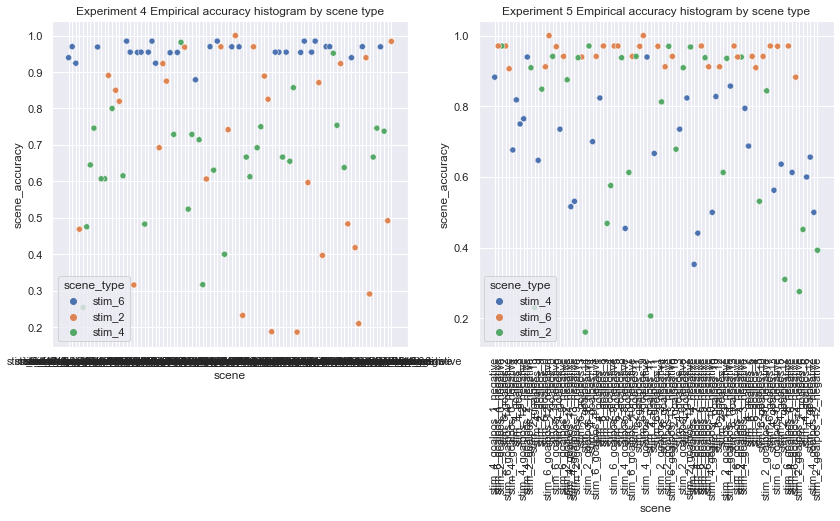

In [32]:
fig, axs = plt.subplots(1,2,figsize=(14,6))
# Title subplots
axs[0].title.set_text("Experiment 4 Empirical accuracy histogram by scene type")
axs[1].title.set_text("Experiment 5 Empirical accuracy histogram by scene type")
sns.scatterplot(x="scene",y='scene_accuracy',hue='scene_type',data=responses.loc[responses.experiment_version==4],ax=axs[0])
plt.xticks(rotation=90);
sns.scatterplot(x="scene",y='scene_accuracy',hue='scene_type',data=responses.loc[responses.experiment_version==5],ax=axs[1])
plt.xticks(rotation=90);

# Modeling

In line with good dataframe practice, we create a copy of our `responses` dataframe for our modeling efforts and name it `model`.

In [33]:
# Make a copy of our resposnes dataframe
model = responses

**Model parameters:** While we haven't fit our model to the data yet, we can use our best-fitting parameter settings from our last experiment. These are:

**N: 35
D: 200
E: 0.9**

In [34]:
# Working parameters (for now)
model_parameters = (35, 200, 0.99)

## Computing model predictions

### Simulation time predictions

#### Computing simulation times per scene

**Computing simulation times:** Here we're going through each of the scenarios given to participants and computing the expected simulation time for each scenario according to a full simulation model `model_sim` and an abstraction model `model_abs`. We store these results in our dataframe `model`.

In [35]:
# Director with relevant JSONs
loaddir = "../data/json/pilot4/trial/"
# Gather all of the json files in the directory of trial stimuli
json_files = [pos_json for pos_json in os.listdir(loaddir) if pos_json.endswith('.json')]

In [36]:
# Dictionary that will contain our model results
simtime = {}

# Iterate through stimuli files
for file in json_files:
    # Scene name
    scene_name = file.split(".")[0]
    # Load the stimuli
    scene = load_scene(loaddir+file)
    # Instatiate the scene
    scene.instantiate_scene()
    # Run our model on the scene, with the given parameter setting
    scene.run_path(False,*model_parameters)
    # Get model-predicted simulation time
    st = scene.physics.tick
    # Add this scene, simulation time prediction to our dictionary
    simtime[scene_name] = st

Now we merge our `model` dataframe with these predictions

In [37]:
# Dataframe with simulation times
sim_predictions = pd.DataFrame.from_dict(simtime, orient='index')
# Reset the index so we can merge these results on the scene variable
sim_predictions = sim_predictions.reset_index()
# Rename the variables appropriately, so they match the variables in model dataframe
sim_predictions = sim_predictions.rename(columns = {'index':'scene',0:'model_abs_rt'})

In [38]:
# Merge the model predictions into our model dataframe
model = model.merge(sim_predictions, on="scene")

Here we repeat the process for the pure simulation model predictions (yes, this should be cleaner / abstracted)

In [39]:
# Dictionary that will contain our model results
simtime = {}

# Iterate through stimuli files
for file in json_files:
    # Scene name
    scene_name = file.split(".")[0]
    # Load the stimuli
    scene = load_scene(loaddir+file)
    # Instatiate the scene
    scene.instantiate_scene()
    # Run our model on the scene, with the given parameter setting
    scene.run(False)
    # Get model-predicted simulation time
    st = scene.physics.tick
    # Add this scene, simulation time prediction to our dictionary
    simtime[scene_name] = st

Now we merge our `model` dataframe with these predictions

In [40]:
# Dataframe with simulation times
sim_predictions = pd.DataFrame.from_dict(simtime, orient='index')
# Reset the index so we can merge these results on the scene variable
sim_predictions = sim_predictions.reset_index()
# Rename the variables appropriately, so they match the variables in model dataframe
sim_predictions = sim_predictions.rename(columns = {'index':'scene',0:'model_sim_rt'})

In [41]:
# Merge the model predictions into our model dataframe
model = model.merge(sim_predictions, on="scene")

#### Computing distances travelled by the Ball

This isn't important for our work, but a necessary step for us to plot our modeling results.

Here, we're computing the distances travelled by the ball for each scenario according to pure simulation, and appending those distances to our `model` dataframe.

In [42]:
# Dictionary that will contain distance travelled per scenario 
distances = {}

# Iterate through stimuli files
for file in json_files:
    # Scene name
    scene_name = file.split(".")[0]
    # Open the JSON file
    with open(loaddir+file, 'r') as f:
        # Grab the scene arguments
        scene_args = json.loads(f.read())
    # Extract the origin (the ball's starting position)
    origin = scene_args['ball_args'][0]
    # Extract the goal position
    goal = scene_args['goal_args'][0]
    # Convert these points into Vec2d for compatibility with pymunk
    origin = Vec2d(*origin)
    goal = Vec2d(*goal)
    # Compute the distance
    distance = origin.get_distance(goal)
    # Add the scene, distance pair into the dataframe
    distances[scene_name] = distance

Now we merge our `model` dataframe with these predictions

In [43]:
# Dataframe with simulation times
distance_df = pd.DataFrame.from_dict(distances, orient='index')
# Reset the index so we can merge these results on the scene variable
distance_df = distance_df.reset_index()
# Rename the variables appropriately, so they match the variables in model dataframe
distance_df = distance_df.rename(columns = {'index':'scene',0:'distance'})

In [44]:
# Merge the distance values with our model dataframe
model = model.merge(distance_df, on="scene")

## Plotting model predictions

**Plotting predictions:** Here, we're plotting the model predictions of simulation time along with the empirical data.

stim_4.json


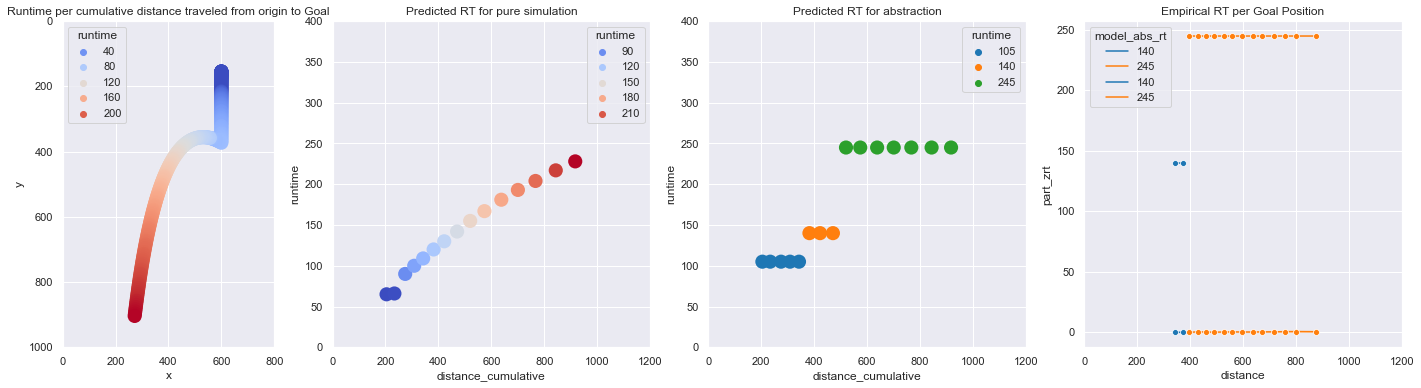

stim_2.json


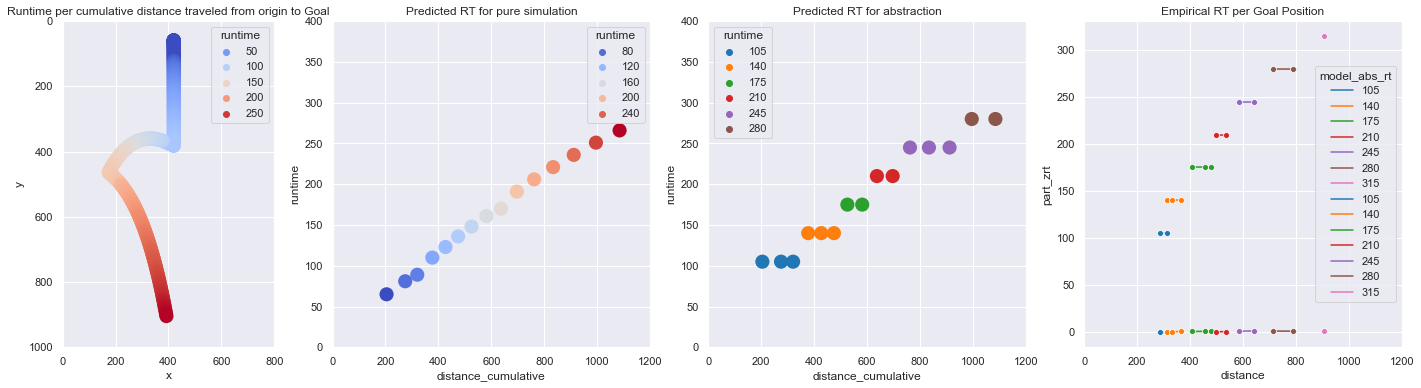

stim_6.json


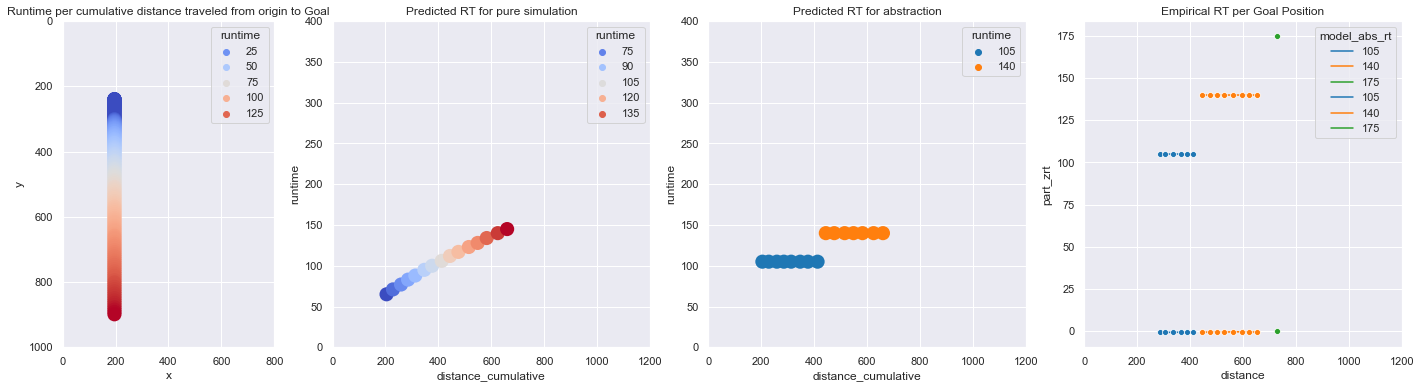

In [45]:
# Directory with relevant JSONs
loaddir = "../data/json/pilot4/types/"
json_files = [pos_json for pos_json in os.listdir(loaddir) if pos_json.endswith('.json')]

for file in json_files:
    print(file)
    # Grab the full trace of ball's trajectory
    full_trace = pilot4.scene_trace(loaddir+file)
    # Grab the sparse trace of ball's trajectory
    sparse_trace = pilot4.get_points(full_trace)
    # Grab RT prediction from simulation model
    sim_full = pilot4.scene_rt(full_trace, loaddir+file)
    
    # Grab RT prediction from abstraction model
    abs_sparse = pilot4.scene_rt(sparse_trace, loaddir+file, abstraction=True,params=model_parameters)
    # Grab RT prediction from simulation model
    sim_sparse = pilot4.scene_rt(sparse_trace, loaddir+file)
    
    # Plot results
    save_plot(df1=sim_full,
              df2=sim_sparse,
              df3=abs_sparse,
              filename=loaddir+file.split('.')[0],
              responses=model)

**Comparing normalized predictions with RT:** Here, we're normalizing the RT predictions of the model and plotting them against the normalized RT data from participants.

In [46]:
model['model_abs_zrt'] = model.groupby('subject_id').model_abs_rt.transform(lambda x: (x - x.mean()) / x.std())
model['model_sim_zrt'] = model.groupby('subject_id').model_sim_rt.transform(lambda x: (x - x.mean()) / x.std())

<AxesSubplot:title={'center':'Experiment 6 rt against Experiment 6 rt'}, xlabel='part_zrt', ylabel='part_zrt'>

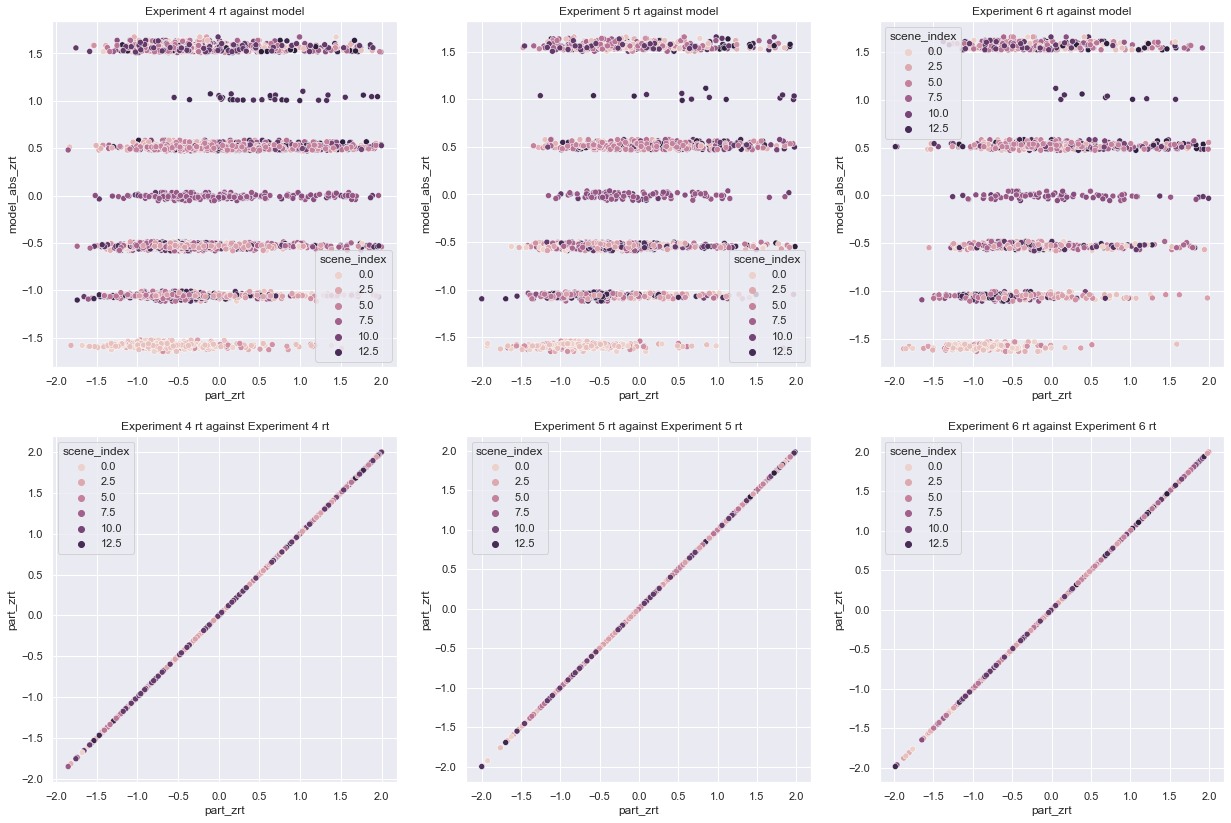

In [64]:
fig, axs = plt.subplots(2,3,figsize=(21,14))
# Title subplots
axs[0,0].title.set_text("Experiment 4 rt against model")
axs[0,1].title.set_text("Experiment 5 rt against model")
axs[0,2].title.set_text("Experiment 6 rt against model")
axs[1,0].title.set_text("Experiment 4 rt against Experiment 4 rt")
axs[1,1].title.set_text("Experiment 5 rt against Experiment 5 rt")
axs[1,2].title.set_text("Experiment 6 rt against Experiment 6 rt")
sns.scatterplot(x="part_zrt",y='model_abs_zrt',hue='scene_index',data=model.loc[(model.experiment_version==4) & (model.correct==True)],ax=axs[0,0])
sns.scatterplot(x="part_zrt",y='model_abs_zrt',hue='scene_index',data=model.loc[(model.experiment_version==5) & (model.correct==True)],ax=axs[0,1])
sns.scatterplot(x="part_zrt",y='model_abs_zrt',hue='scene_index',data=model.loc[(model.experiment_version==6) & (model.correct==True)],ax=axs[0,2])
sns.scatterplot(x="part_zrt",y='part_zrt',hue='scene_index',data=model.loc[(model.experiment_version==4) & (model.correct==True)],ax=axs[1,0])
sns.scatterplot(x="part_zrt",y='part_zrt',hue='scene_index',data=model.loc[(model.experiment_version==5) & (model.correct==True)],ax=axs[1,1])
sns.scatterplot(x="part_zrt",y='part_zrt',hue='scene_index',data=model.loc[(model.experiment_version==6) & (model.correct==True)],ax=axs[1,2])

## Predicting expected variance

**Computing expected variance according to our model:** Here we compute the expected variance in participant response times under our model setting, by computing the variance in the model prediction distribution for each scene.

In [2]:
# Importing our model
from models import abstraction_stochastic

ImportError: cannot import name 'abstraction_stochastic' from 'models' (/Users/lollipop/projects/physics_abstraction/notebooks/../python/models.py)

First, we sample our model for simulation time distributions per scene, and store these samples in `model_distributions` dictionary

In [48]:
# Director with relevant JSONs
loaddir = "../data/json/pilot4/trial/"
# Gather all of the json files in the directory of trial stimuli
json_files = [pos_json for pos_json in os.listdir(loaddir) if pos_json.endswith('.json')]

In [49]:
# Dictionary that will contain our model results
model_distributions = {}

for file in json_files:
    # Scene name
    scene_name = file.split(".")[0]
    # Open the JSON file
    with open(loaddir+file, 'r') as f:
        # Grab the scene arguments
        scene_args = json.loads(f.read())
    model_distributions[scene_name] = abstraction_stochastic(scene_args,*model_parameters,90)

We then convert `model_predictions` into a usable dataframe `predictions` and format it for ease of use

In [50]:
# Placing model predicted distributions into datframe, using scenes as rows
predictions = pd.DataFrame.from_dict(model_distributions,orient='index')

In [51]:
# Making the scenes their own variable, so we can merge on the `scene` variable with other dataframes
predictions = predictions.reset_index()
predictions = predictions.rename(columns={'index':'scene'})

Because of the return value of our model, I am simply flattening the list of lists of simulation times into a list of simulation times.

In [52]:
# Flattening the list of simulation times (needs to be fixed in model.py)
predictions.simulation_time = predictions.simulation_time.transform(lambda x: [y[0] for y in x])

Copying our `predictions` dataframe for cleanliness

In [53]:
df = predictions

Here, we gather the variables we want to merge with our predictions from our `model` dataframe.

In [54]:
grouping_df = model[['scene','model_abs_rt','scene_type','distance','scene_col']].drop_duplicates()

Then, we merge the dataframes

In [55]:
df = df.merge(grouping_df,on='scene')

We have a list of simulation times, but we need each element occupies an individual row in our dataframe so we can work with the data easily.

In [56]:
df = df.explode('simulation_time')

Then, we compute the variable-wise (across scenes) normalized predicted simulation times for comparison with participant responses times. We store these normalized simulation times as `sim_time_z`

In [57]:
df['sim_time_z'] = df.simulation_time.transform(lambda x: (x-x.mean())/x.std())

In [58]:
# Resetting the index
df = df.reset_index(drop=True)

**Plot model predictions against empirical RT:** Here, we're plotting the model predictions against our RT.

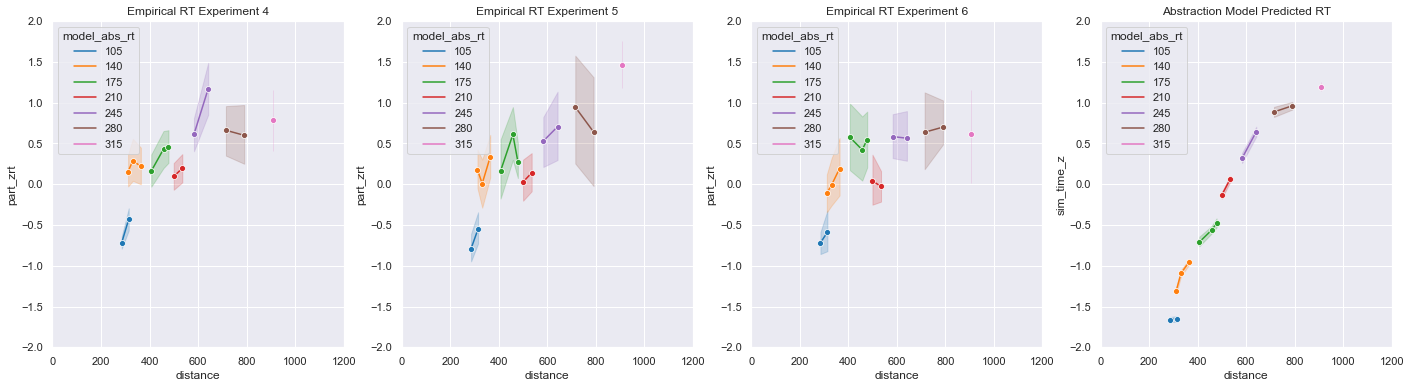

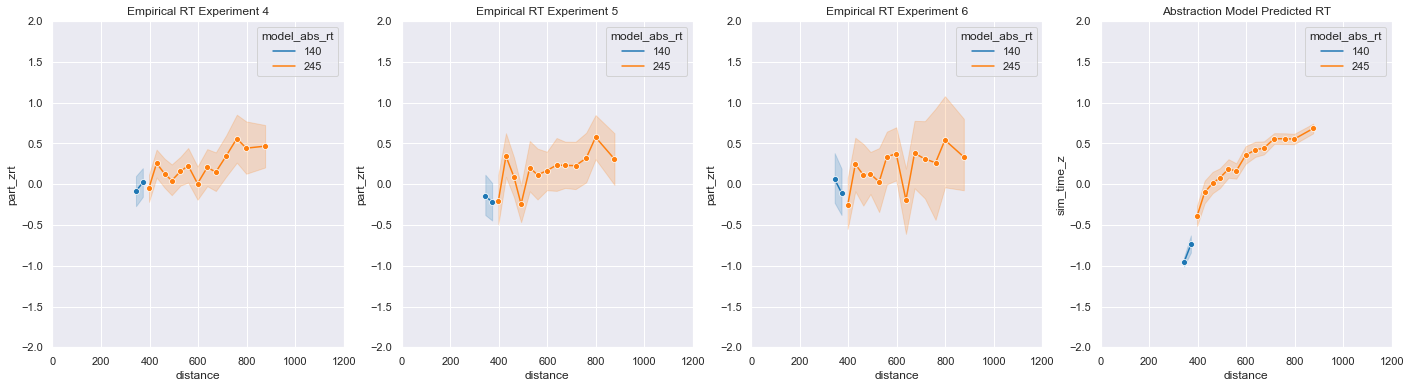

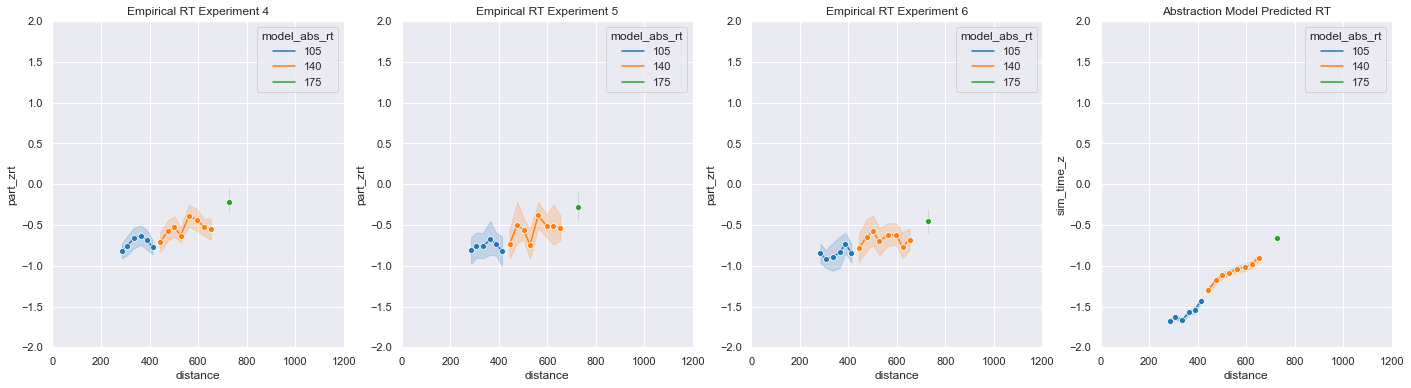

In [70]:
for scene_type in ['stim_2','stim_4','stim_6']:
    # Set figure object
    fig, axs = plt.subplots(1,4,figsize=(24,6))

    # Title subplots
    axs[0].title.set_text("Empirical RT Experiment 4")
    axs[1].title.set_text("Empirical RT Experiment 5")
    axs[2].title.set_text("Empirical RT Experiment 6")
    axs[3].title.set_text("Abstraction Model Predicted RT")
    
    # Plots
    g = sns.lineplot(x='distance',
                     y='part_zrt',
                     data=model.loc[
                         (model.scene_type == scene_type) 
                         & (model.scene_col == "yes") 
                         & (model.correct == True) 
                         & (model.experiment_version == 4)
                     ],
                     hue='model_abs_rt',
                     marker='o', ci=95,
                     palette="tab10",
                     ax=axs[0])
    g.set(xlim=(0,1200),ylim=(-2,2))
    
    g = sns.lineplot(x='distance',
                     y='part_zrt',
                     data=model.loc[
                         (model.scene_type == scene_type) 
                         & (model.scene_col == "yes") 
                         & (model.correct == True)
                         & (model.experiment_version == 5)
                     ],
                     hue='model_abs_rt',
                     marker='o', ci=95,
                     palette="tab10",
                     ax=axs[1])
    g.set(xlim=(0,1200),ylim=(-2,2))
    
    g = sns.lineplot(x='distance',
                     y='part_zrt',
                     data=model.loc[
                         (model.scene_type == scene_type) 
                         & (model.scene_col == "yes") 
                         & (model.correct == True)
                         & (model.experiment_version == 6)
                     ],
                     hue='model_abs_rt',
                     marker='o', ci=95,
                     palette="tab10",
                     ax=axs[2])
    g.set(xlim=(0,1200),ylim=(-2,2))

    g = sns.lineplot(x='distance',
                     y='sim_time_z',
                     data=df.loc[
                         (df.scene_type == scene_type) 
                         & (df.scene_col == "yes")
                     ],
                     hue='model_abs_rt',
                     marker='o', ci=95,
                     palette="tab10",
                     ax=axs[3])
    g.set(xlim=(0,1200),ylim=(-2,2))
    
    

In [60]:
len(pd.unique(responses.loc[(responses.scene_type=='stim_2') & (responses.scene_accuracy > 0.7) & (responses.scene_col == 'yes')].scene))

8

### Summary statistic

In [61]:
model['model_grouping'] = model.model_abs_rt.astype(object)
df['model_grouping'] = df.model_abs_rt.astype(object)

In [62]:
scene_types = ['stim_2','stim_4','stim_6']
scene_type_groups = {s:pd.unique(model[model.scene_type == s].model_grouping) for s in scene_types}

# Compute difference between within-group var and across-group var
for s in scene_types:
    print(f"Scene {s}")
    g = scene_type_groups[s]
    g.sort()
    print(f"Groups {g}")
    for idx in range(1,len(scene_type_groups[s])):
        print(f"\tGroup {g[idx-1],g[idx]}")
        # Grab normalized RT for first group
        within_group_rt = model[(model.scene_type == s) & (model.model_grouping==g[idx-1])].part_zrt.to_list()
        # Grab normalized RT for second group
        across_group_rt = model[(model.scene_type == s) & (model.model_grouping==g[idx])].part_zrt.to_list()
        across_group_rt += within_group_rt
        print(f"\tWithin-group variance {np.var(within_group_rt)}")
        print(f"\tAcross-group variance {np.var(across_group_rt)}")
        
        # Grab normalized RT for first group
        within_group_rt = df[(df.scene_type == s) & (df.model_grouping==g[idx-1])].sim_time_z.to_list()
        # Grab normalized RT for second group
        across_group_rt = df[(df.scene_type == s) & (df.model_grouping==g[idx])].sim_time_z.to_list()
        across_group_rt += within_group_rt
        print(f"\tWithin-group variance {np.var(within_group_rt)}")
        print(f"\tAcross-group variance {np.var(across_group_rt)}")

Scene stim_2
Groups [105 140 175 210 245 280 315]
	Group (105, 140)
	Within-group variance 0.25871118792599274
	Across-group variance 0.5556494174971577
	Within-group variance 0.026293279833964366
	Across-group variance 0.11133091957619767
	Group (140, 175)
	Within-group variance 0.5160130166107808
	Across-group variance 0.5385099467660757
	Within-group variance 0.053360140171789805
	Across-group variance 0.13651599943477097
	Group (175, 210)
	Within-group variance 0.5562366944470571
	Across-group variance 0.5194805885702144
	Within-group variance 0.07568132368266717
	Across-group variance 0.13518147471783828
	Group (210, 245)
	Within-group variance 0.44482830280885366
	Across-group variance 0.5255896450940222
	Within-group variance 0.042399270618124825
	Across-group variance 0.1473884889514957
	Group (245, 280)
	Within-group variance 0.5795004711240191
	Across-group variance 0.6254911013679391
	Within-group variance 0.1201056087102612
	Across-group variance 0.14569628273481214
	Group 

# RT Analysis

In [49]:
# Ticks of basic stimuli
stim_2_ticks = 285
stim_4_ticks = 247
stim_6_ticks = 163

In [50]:
# RT conversion
stim_2_ms = stim_2_ticks / 60 * 1000
stim_4_ms = stim_2_ticks / 60 * 1000
stim_6_ms = stim_2_ticks / 60 * 1000

In [51]:
scene_to_ms = {
    'stim_2':stim_2_ms,
    'stim_4':stim_4_ms,
    'stim_6':stim_6_ms
}

In [52]:
loaddir = "../data/json/pilot4/types/"
json_files = [pos_json for pos_json in os.listdir(loaddir) if pos_json.endswith('.json')]

In [53]:
def plot_rt_on_stim(df):
    '''
    Takes in an RT, and plots a point where
    the ball would have been at that time
    
    Needs: trace of ball, rt
    '''
    fig, axs = plt.subplots(figsize=(8,10))
    # Ball trace
    trace = pilot4.scene_trace(loaddir+json_files[1])
    df['tick'] = df.rt.apply(lambda x: int(x * 60 / 1000) if x < stim_2_ms else len(trace)-1)
    df['tick'] = df.tick.apply(lambda x: len(trace)-1 if x > len(trace)-1 else x)
    df['x'] = df.tick.apply(lambda x: trace[x][0])
    df['y'] = df.tick.apply(lambda x: trace[x][1])
    g=sns.scatterplot(x="x", 
                      y="y", 
                      hue="experiment_version",
                      s=200,
                      data=df,
                      palette="tab10",
                      edgecolor="none")
    g.set(ylim=(0, 1000),xlim=(0,800))
    g.invert_yaxis()
        

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=(800,1000),range=[[0, 800], [0, 1000]])
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

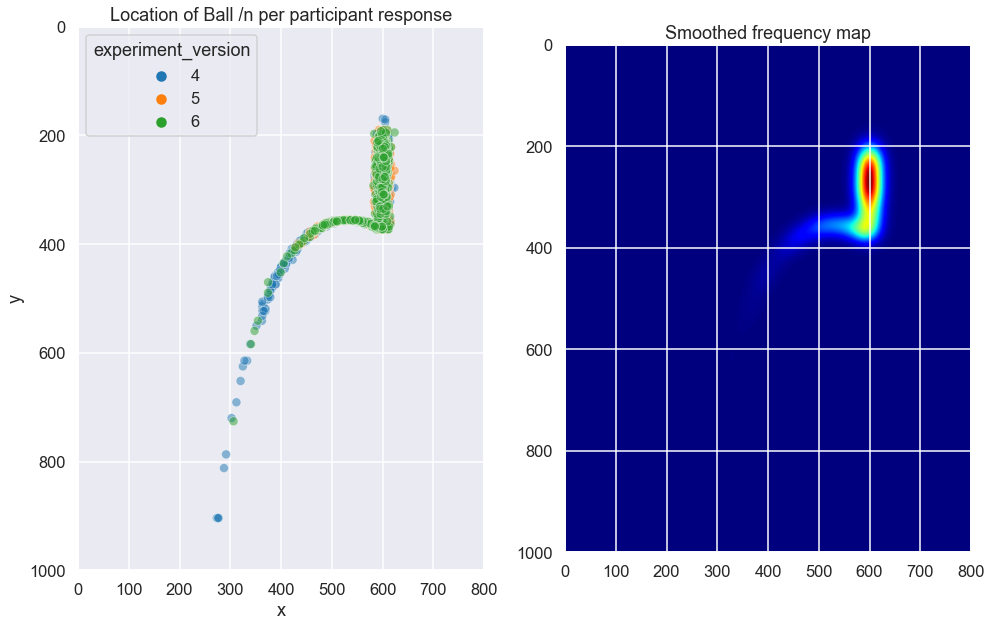

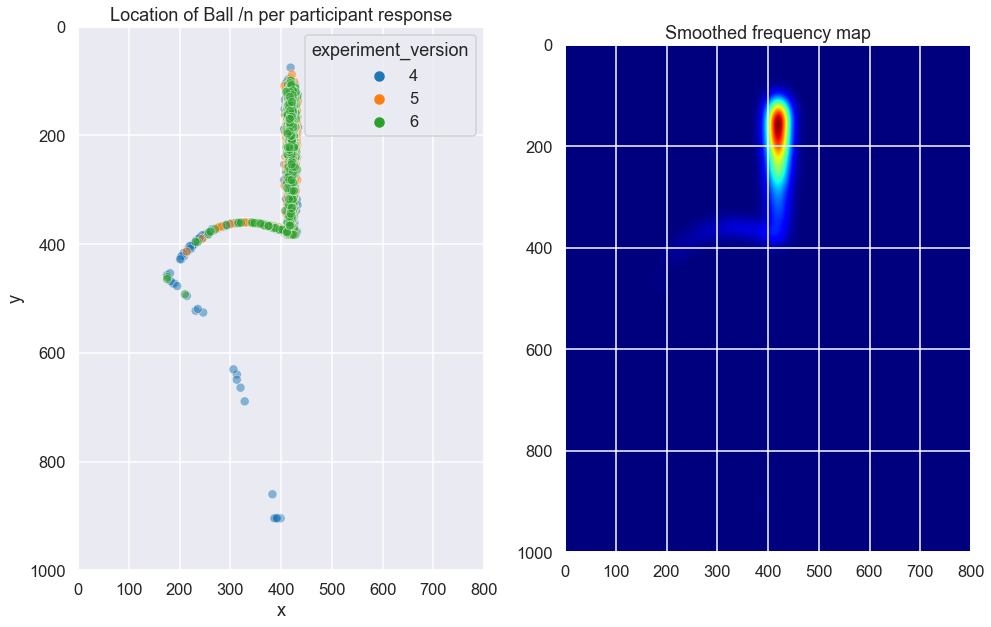

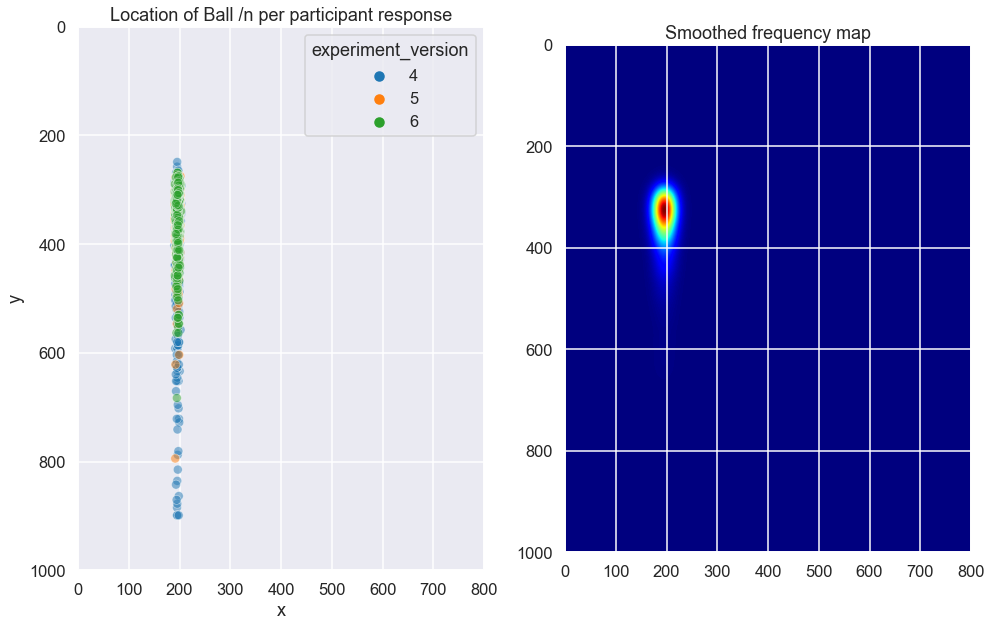

In [72]:

    
for idx,file in enumerate(json_files):
    idx=0
    fig, axs = plt.subplots(1,2,figsize=(16,10))
    axs[0].title.set_text("Location of Ball /n per participant response")
    axs[1].title.set_text("Smoothed frequency map")
    sns.set_context("talk")
    scene = file.split('.')[0]
    # Ball trace
    trace = pilot4.scene_trace(loaddir+file)
    df = responses.loc[(responses.scene_type == scene) & responses.scene_col == True][['rt','subject_id','experiment_version','scene_index','response']]
    df['tick'] = df.rt.apply(lambda x: int(x * 60 / 1000) if x < scene_to_ms[scene] else len(trace)-1)
    df['tick'] = df.tick.apply(lambda x: len(trace)-1 if x > len(trace)-1 else x)
    df['x'] = df.tick.apply(lambda x: trace[x][0])
    df.x = df.x.apply(lambda x: x*np.random.normal(1,0.01))
    df['y'] = df.tick.apply(lambda x: trace[x][1])
    g=sns.scatterplot(x="x", 
                      y="y", 
                      hue="experiment_version",
                      alpha=0.5,
                      data=df,
                      palette="tab10",
                      ax=axs[0])
    g.set(ylim=(0, 1000),xlim=(0,800))
    g.invert_yaxis()

    # Generate some test data
    x = df.x
    y = df.y
    s = 16
    img, extent = myplot(x, y, s)
    axs[1].imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    axs[1].invert_yaxis()

plt.show()

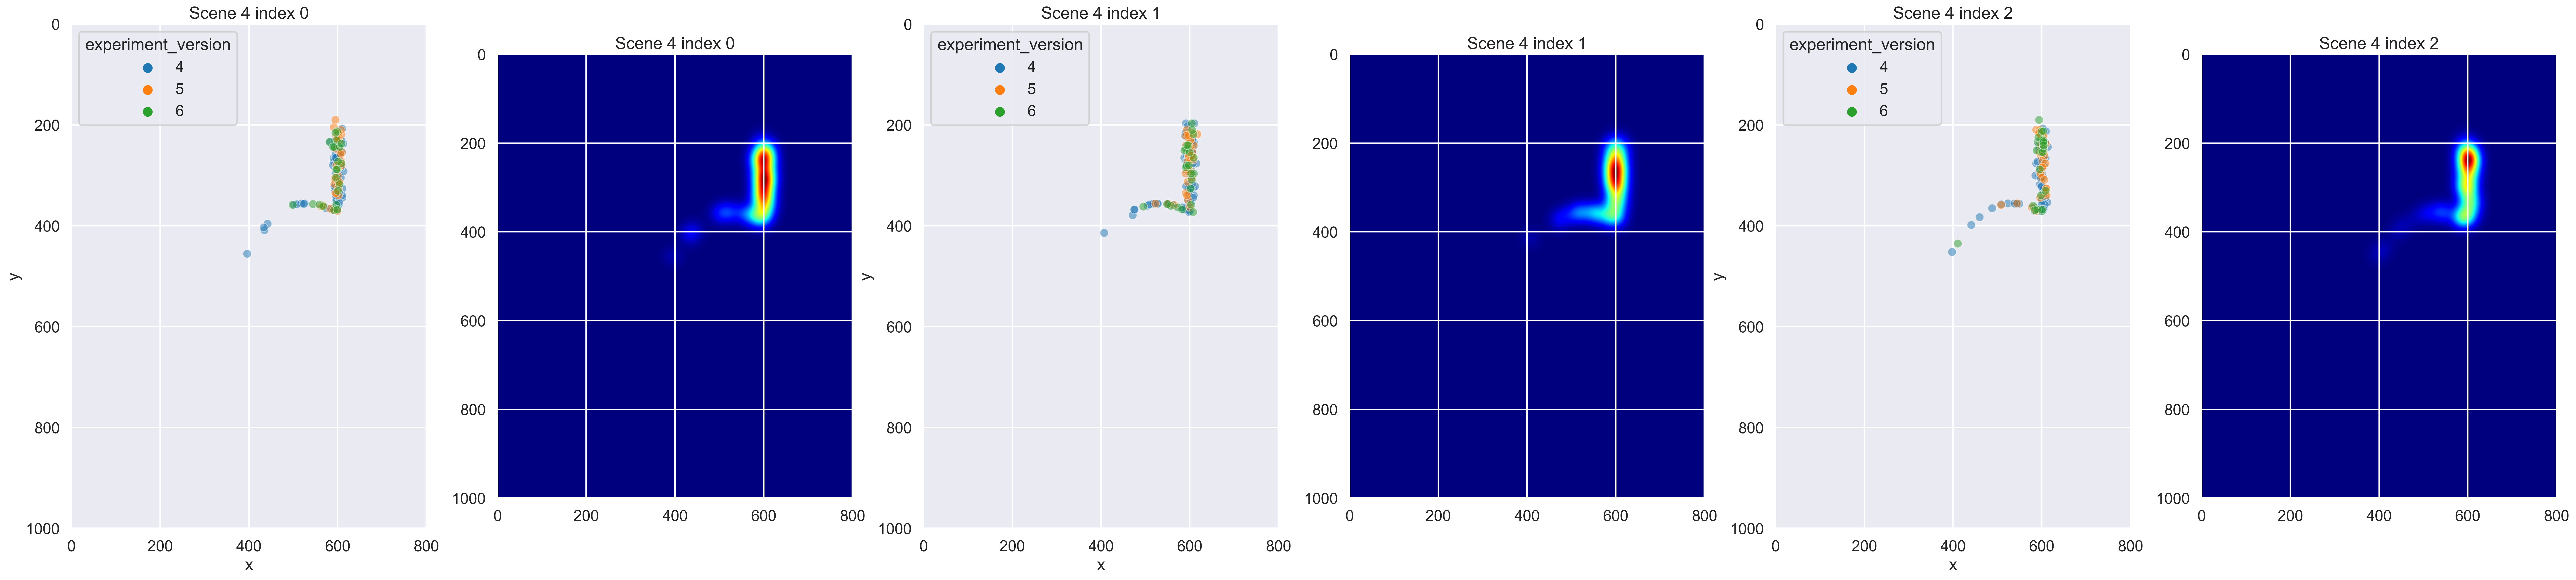

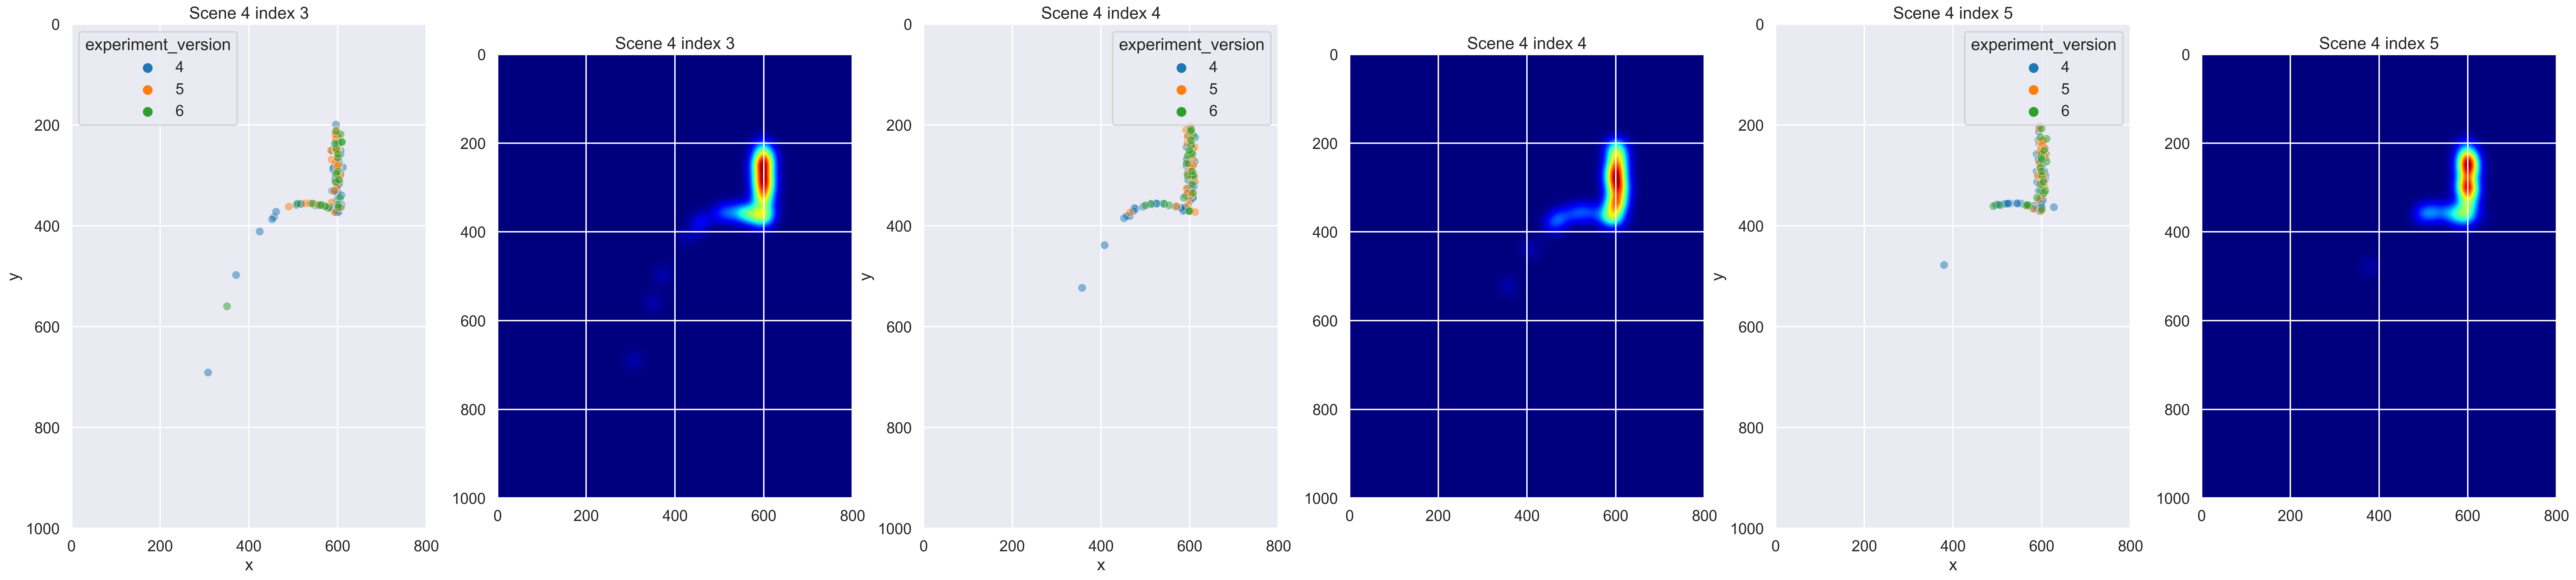

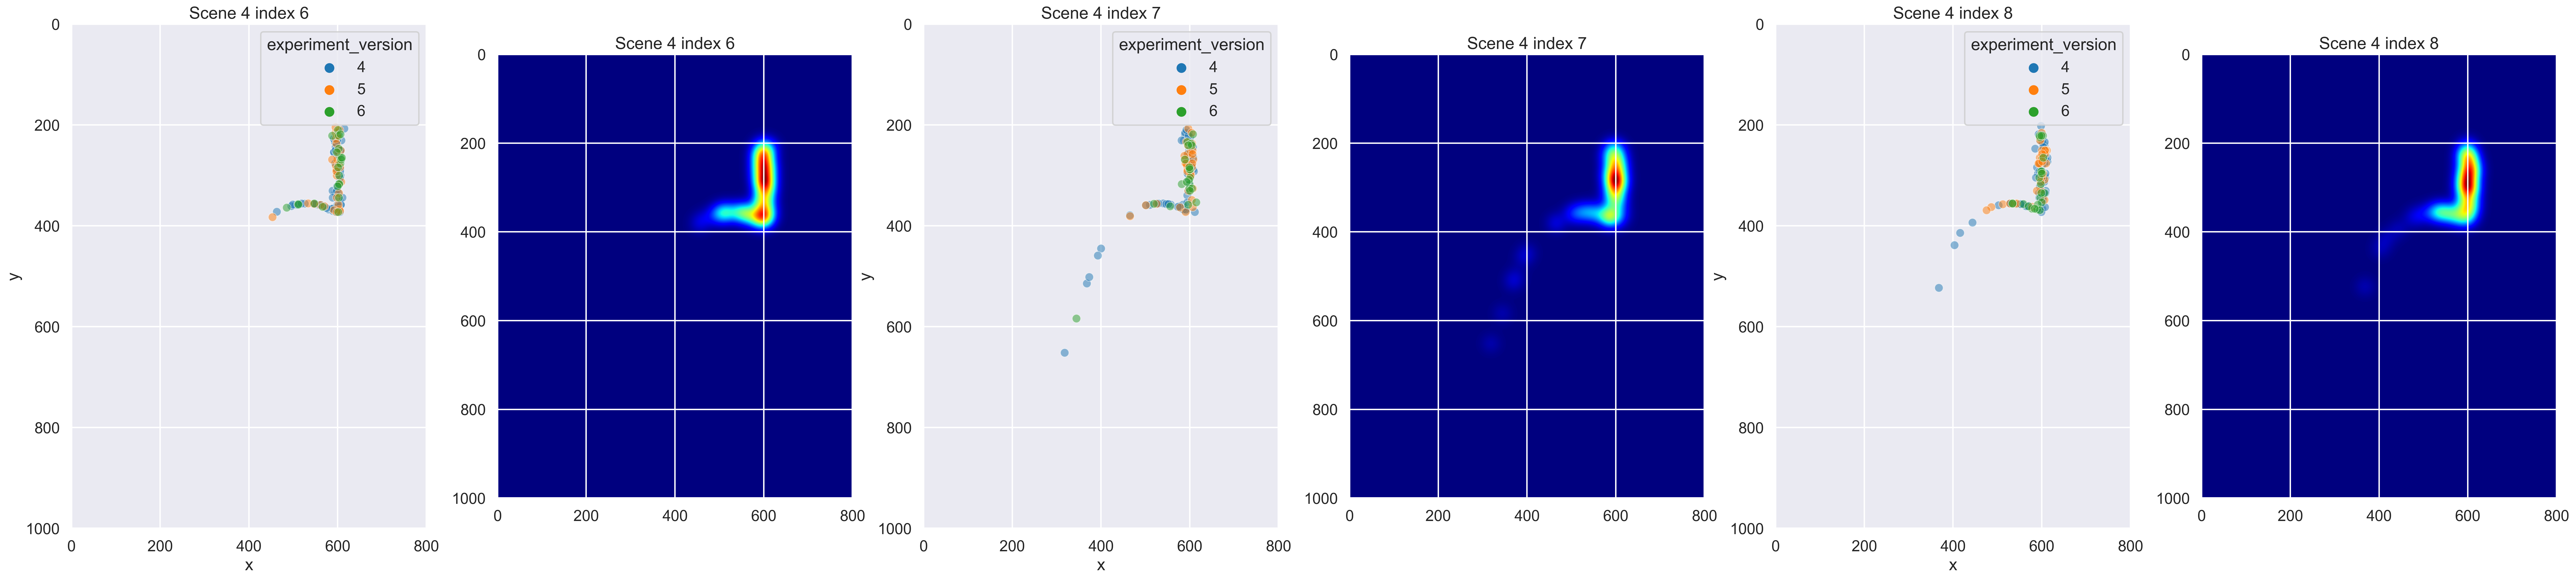

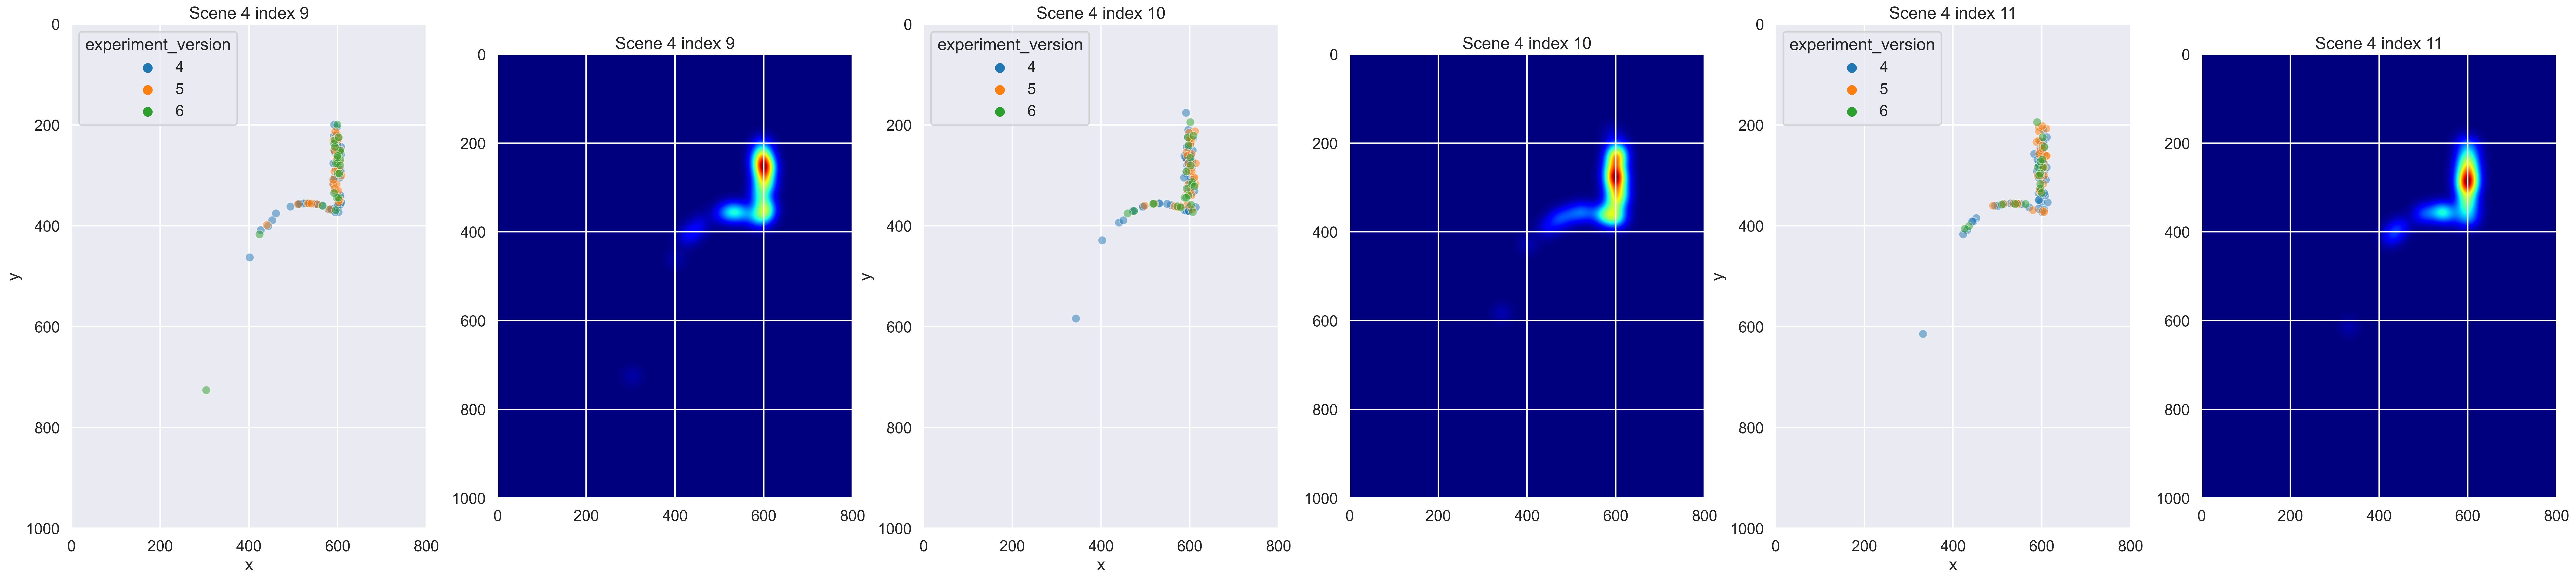

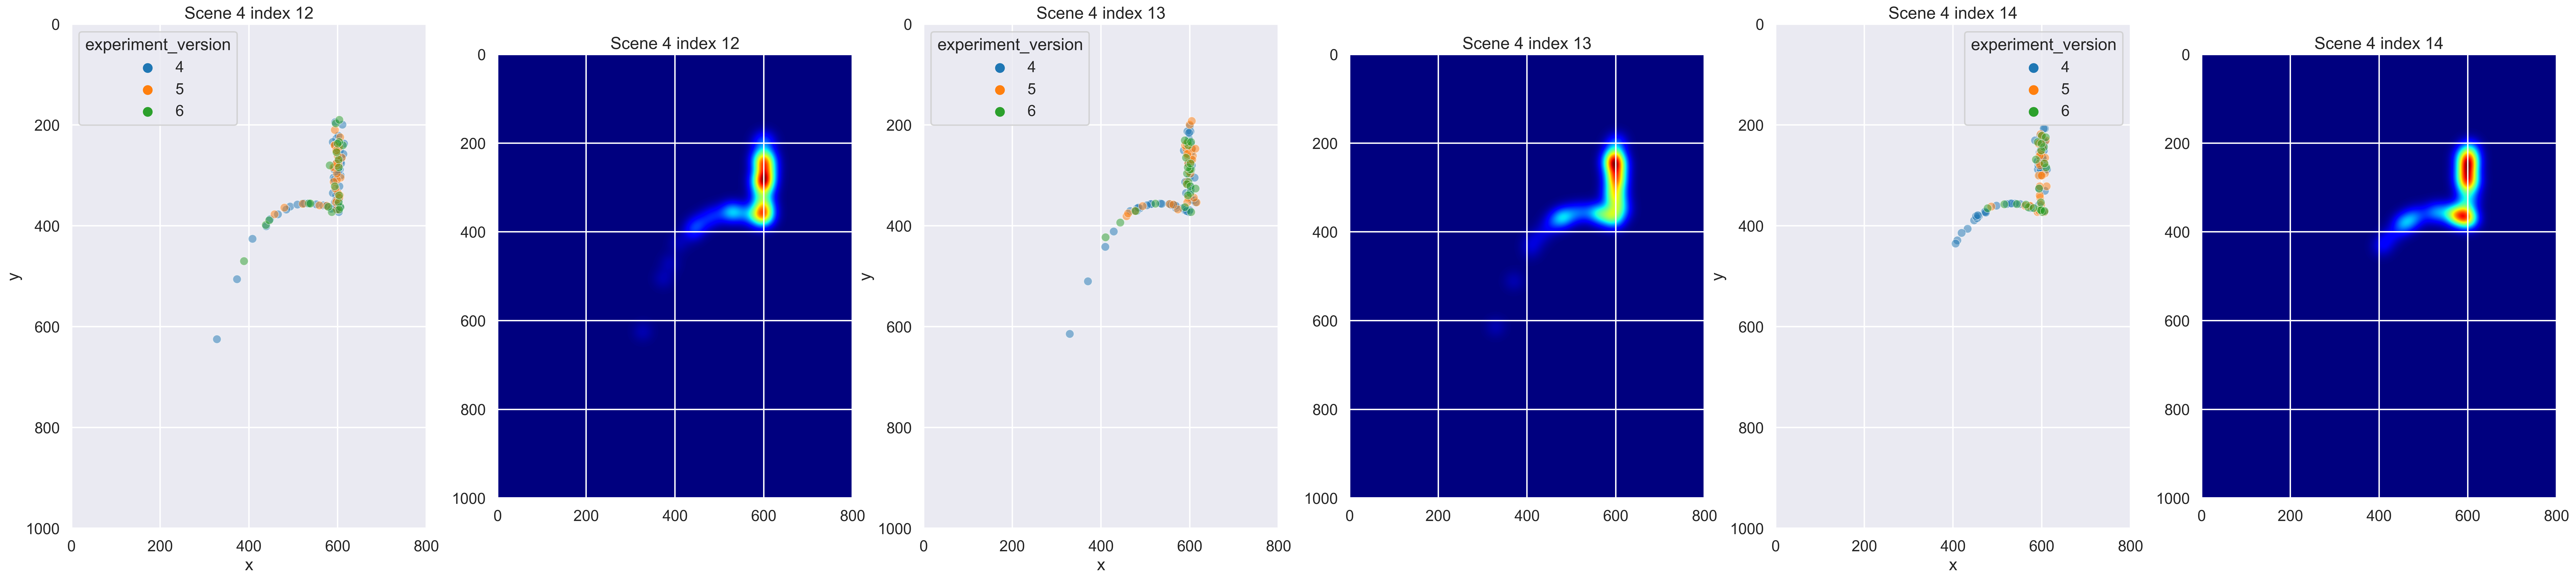

In [86]:
for file in json_files[:1]:
    scene = file.split('.')[0]
    for i in range(5):
        fig, axs = plt.subplots(1,6,figsize=(48,10),dpi=300)
        for j_idx,j in enumerate(range(i*3,i*3+3)):
            # Ball trace
            trace = pilot4.scene_trace(loaddir+file)
            df = responses.loc[(responses.scene_type == scene) 
                               & (responses.scene_col == 'yes') 
                               & (responses.scene_index == j+0.0)
                              ][
                ['rt',
                 'subject_id',
                 'experiment_version',
                 'scene_index',
                 'response',
                 'scene']
            ]
            df['tick'] = df.rt.apply(lambda x: int(x * 60 / 1000) if x < scene_to_ms[scene] else len(trace)-1)
            df['tick'] = df.tick.apply(lambda x: len(trace)-1 if x > len(trace)-1 else x)
            df['x'] = df.tick.apply(lambda x: trace[x][0])
            df.x = df.x.apply(lambda x: x*np.random.normal(1,0.01))
            df['y'] = df.tick.apply(lambda x: trace[x][1])
            
            g=sns.scatterplot(x="x", 
                              y="y", 
                              hue="experiment_version",
                              alpha=0.5,
                              data=df,
                              palette="tab10",
        #                       edgecolor="none",
                              ax=axs[j_idx*2])
            g.set(ylim=(0, 1000),xlim=(0,800),title=f"Scene {scene.split('_')[1]} index {j}")
            g.invert_yaxis()

            # Generate some test data
            x = df.x
            y = df.y
            s = 16
            img, extent = myplot(x, y, s)
            axs[j_idx*2+1].imshow(img, extent=extent, origin='lower', cmap=cm.jet)
            axs[j_idx*2+1].set_title(f"Scene {scene.split('_')[1]} index {j}")
            axs[j_idx*2+1].invert_yaxis()

        plt.show()

In [57]:
responses.scene_type[659] == 'stim_6'

True

<AxesSubplot:xlabel='scene_index', ylabel='part_zrt'>

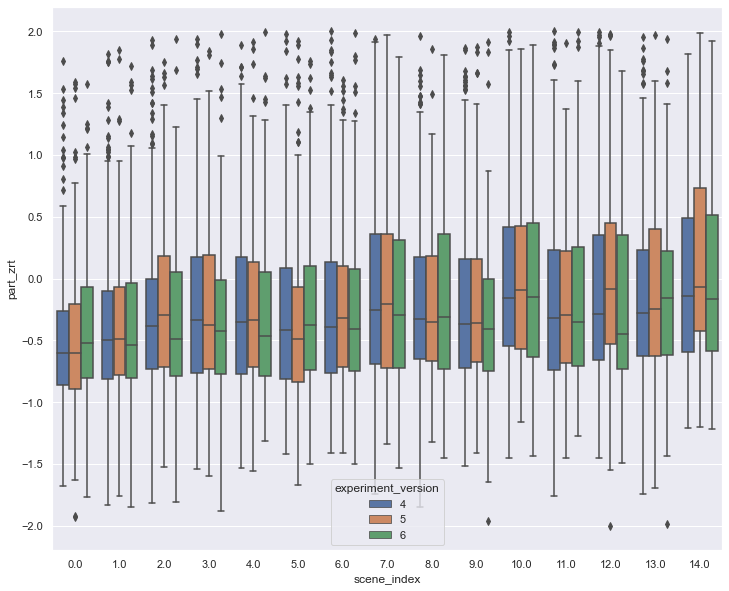

In [58]:
sns.boxplot(x='scene_index',y='part_zrt',hue='experiment_version',data=responses.loc[responses.correct==True])

In [1]:
responses.to_json


NameError: name 'responses' is not defined

In [81]:
df.sort_values('rt', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')[:40]

rt                subject_id  experiment_version  scene_index  \
30626  2451.0  6106e48e1c2d2ed1c883face                   4         14.0   
10627  2420.0  6171e05a8bd75852eeb6b0bc                   4         14.0   
16412  2348.0  5d1e4a3ed4b9d60001ec8f1c                   4         14.0   
3571   2296.0  5d59ca6698cf220016ec5708                   4         14.0   
10037  2170.0  6047f8c69fa4a010d97013ac                   4         14.0   
30042  2146.0  5f50dcfd4490ae26df5fbb3a                   4         14.0   
24305  2116.0  60b97d2809d43ab2f0614bb9                   4         14.0   
34413  2110.0  60e0b3c47c19ee6ccb2b4a3a                   4         14.0   
44762  2092.0  5bb20ae1ec73cb00011d60e8                   4         14.0   
28964  2043.0  5fc3f24cdb80f92ddc47afa1                   4         14.0   
21298  2024.0  607b494b3fe36c9f87d169db                   4         14.0   
2747   2020.0  6005c01be34dba4d8e9f3b39                   4         14.0   
96166  1935.0  57eab4e521d77800018e572e                   6         14.0   
70145  1892.0  5ee553807b5efd29e9dad484                   5         14.0   
51608  1862.0  5eb16c316e577a06b326d39c                   4         14.0   
90651  1793.0  612d7a091f07a781591d1224                   6         14.0   
19958  1781.0  5a9aa66a35237b000112937b                   4         14.0   
7374   1690.0  6166e0c6cb669c0c492ae55e                   4         14.0   
32121  1666.0  5d015fc114edab0001e096e9                   4         14.0   
28059  1647.0  61544ec77d9db5f95283802e                   4         14.0   
14873  1597.0  6122ae9b67e54054793dcc3e                   4         14.0   
83446  1595.0  61096729ba7c19154efa462d                   6         14.0   
89956  1562.0  5e9378c1facc7d6c21fa8310                   6         14.0   
74490  1508.0  614d19790cfe2cc1fd096ba7                   5         14.0   
65154  1503.0  5e28e045fce1f40a73809269                   5         14.0   
72096  1492.0  60cc889d5bbfb9535a13f18f                   5         14.0   
46255  1489.0  61215dfd964b036be83dd813                   4         14.0   
26019  1475.0  5ee373e3cc1ea60299985b8a                   4         14.0   
15453  1474.0  5d8a5eaf689e58001a8ad452                   4         14.0   
28469  1467.0  613b1df97dec5ae6d1130560                   4         14.0   
86892  1465.0  607bf7e637122f12ab463e17                   6         14.0   
32750  1442.0  5f761e5106b786071f45b4aa                   4         14.0   
13410  1436.0  5ff0a3d22c2ee6fa5d47c312                   4         14.0   
88668  1434.0  5e8249e7cee0da961f8f08f5                   6         14.0   
77170  1430.0  5e8a066ae2eb0669f756253a                   6         14.0   
84695  1398.0  610e84060ea4d4e60d0fc857                   6         14.0   
56074  1398.0  61623853a4ccad551beeb11a                   5         14.0   
80324  1392.0  601d916593209b155c1a49d2                   6         14.0   
22749  1382.0  5c05922f4e1b7b00016af702                   4         14.0   
57490  1373.0  60087e9189ddb34b79b08be5                   5         14.0   

      response              scene  tick           x           y  
30626        j  stim_4_goalpos_14   147  404.350096  435.177511  
10627        f  stim_4_goalpos_14   145  409.468561  428.865148  
16412        j  stim_4_goalpos_14   140  427.569019  414.095689  
3571         f  stim_4_goalpos_14   137  430.466929  405.947560  
10037        j  stim_4_goalpos_14   130  453.142612  389.107069  
30042        j  stim_4_goalpos_14   128  458.672451  384.873298  
24305        j  stim_4_goalpos_14   126  462.450867  380.904440  
34413        f  stim_4_goalpos_14   126  459.145308  380.904440  
44762        f  stim_4_goalpos_14   125  460.324315  379.020771  
28964        f  stim_4_goalpos_14   122  466.025588  373.779737  
21298        j  stim_4_goalpos_14   121  470.911898  372.171335  
2747         j  stim_4_goalpos_14   121  483.704466  372.171335  
96166        j  stim_4_goalpos_14   

In [92]:
df = responses.groupby('scene').rt.apply(lambda x: sum(x) / len(x))

In [94]:
df.sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

scene
stim_2_goalpos_14_negative    1360.528846
stim_2_goalpos_10             1356.236364
stim_4_goalpos_10_negative    1307.426087
stim_2_goalpos_7              1307.179487
stim_2_goalpos_12_negative    1296.155963
                                 ...     
stim_6_goalpos_4               861.918699
stim_6_goalpos_6               859.422764
stim_2_goalpos_0               850.604839
stim_6_goalpos_1               847.032520
stim_6_goalpos_5               843.612903
Name: rt, Length: 90, dtype: float64

In [99]:
responses.groupby('part_zrt').apply(lambda x: sum(x) / len(x))

TypeError: unsupported operand type(s) for +: 'int' and 'str'

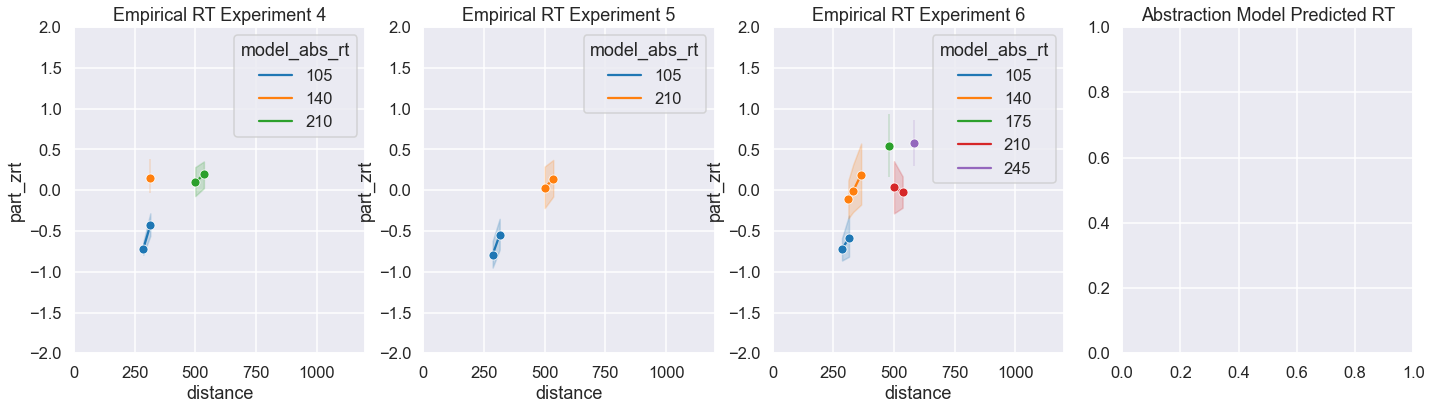

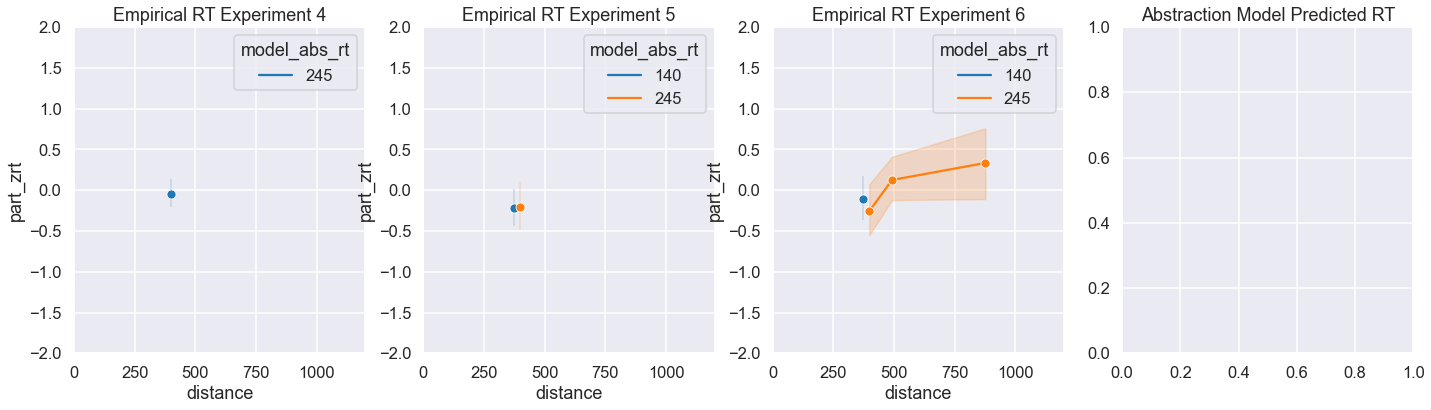

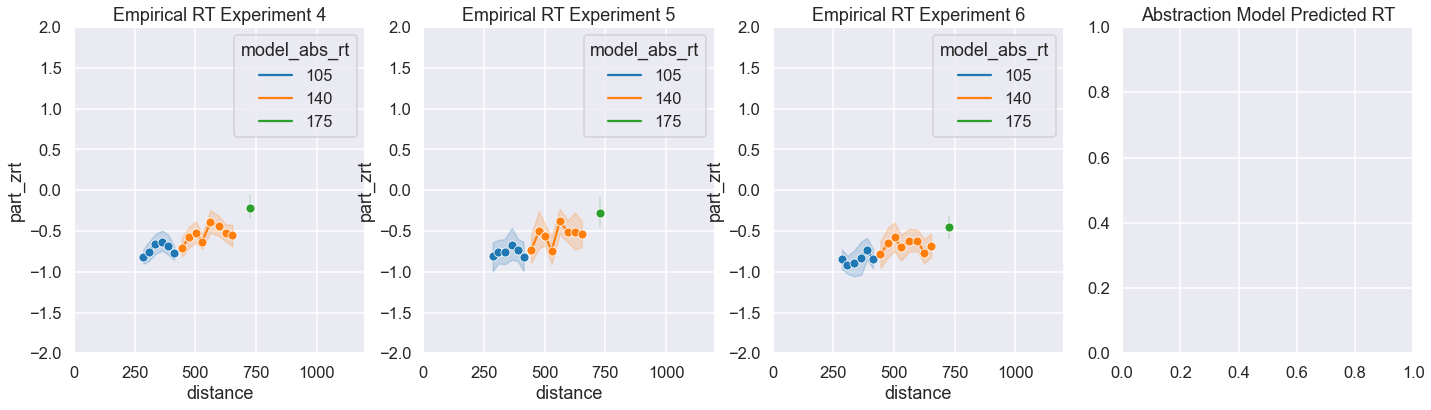

In [109]:
acc = 0.8
for scene_type in ['stim_2','stim_4','stim_6']:
    # Set figure object
    fig, axs = plt.subplots(1,4,figsize=(24,6))

    # Title subplots
    axs[0].title.set_text("Empirical RT Experiment 4")
    axs[1].title.set_text("Empirical RT Experiment 5")
    axs[2].title.set_text("Empirical RT Experiment 6")
    axs[3].title.set_text("Abstraction Model Predicted RT")
    
    # Plots
    g = sns.lineplot(x='distance',
                     y='part_zrt',
                     data=model.loc[
                         (model.scene_type == scene_type) 
                         & (model.scene_col == "yes") 
                         & (model.correct == True) 
                         & (model.experiment_version == 4)
                         & (model.scene_index_accuracy > acc)
                     ],
                     hue='model_abs_rt',
                     marker='o', ci=95,
                     palette="tab10",
                     ax=axs[0])
    g.set(xlim=(0,1200),ylim=(-2,2))
    
    g = sns.lineplot(x='distance',
                     y='part_zrt',
                     data=model.loc[
                         (model.scene_type == scene_type) 
                         & (model.scene_col == "yes") 
                         & (model.correct == True)
                         & (model.experiment_version == 5)
                         & (model.scene_index_accuracy > acc)
                     ],
                     hue='model_abs_rt',
                     marker='o', ci=95,
                     palette="tab10",
                     ax=axs[1])
    g.set(xlim=(0,1200),ylim=(-2,2))
    
    g = sns.lineplot(x='distance',
                     y='part_zrt',
                     data=model.loc[
                         (model.scene_type == scene_type) 
                         & (model.scene_col == "yes") 
                         & (model.correct == True)
                         & (model.experiment_version == 6)
                         & (model.scene_index_accuracy > acc)
                     ],
                     hue='model_abs_rt',
                     marker='o', ci=95,
                     palette="tab10",
                     ax=axs[2])
    g.set(xlim=(0,1200),ylim=(-2,2))

trial_index                subject_id condition      rt response  \
0               58  6018059e3161f7ad97ac5b44         f  1128.0        f   
1              462  6005c01be34dba4d8e9f3b39         f   891.0        f   
2              497  6160b2a2c45a000804632bbf         j  1203.0        j   
3              113  5d59ca6698cf220016ec5708         f   992.0        f   
4              442  5faebc4fd268c80246d61736         f   741.0        f   
...            ...                       ...       ...     ...      ...   
10641          168  616fe864779b03fb52e78c35         j  1184.0        f   
10642          268  60fd53b7ece85e2d83a65501         f   676.0        j   
10643          142  57eab4e521d77800018e572e         f  1328.0        j   
10644          482  60e843f0bf01b40223cb118f         f   612.0        j   
10645          302  5f452661c5a1b50a817ab094         j   828.0        f   

      correct_response correct task_condition                       scene  \
0                    f    True            yes            stim_6_goalpos_3   
1                    f    True            yes            stim_6_goalpos_3   
2                    j    True            yes            stim_6_goalpos_3   
3                    f    True            yes            stim_6_goalpos_3   
4                    f    True            yes            stim_6_goalpos_3   
...                ...     ...            ...                         ...   
10641                f    True             no  stim_2_goalpos_11_negative   
10642                j    True             no  stim_2_goalpos_11_negative   
10643                j    True             no  stim_2_goalpos_11_negative   
10644                j    True             no  stim_2_goalpos_11_negative   
10645                f    True             no  stim_2_goalpos_11_negative   

      scene_type  ...   var_zrt  part_zrt scene_accuracy  part_accuracy  \
0         stim_6  ... -0.138199  0.506773       0.939394       0.701149   
1         stim_6  ... -0.506039 -0.775490       0.939394       0.705882   
2         stim_6  ... -0.021794 -1.028285       0.939394       0.825581   
3         stim_6  ... -0.349281 -0.722439       0.939394       0.860465   
4         stim_6  ... -0.738850 -0.654150       0.939394       0.732558   
...          ...  ...       ...       ...            ...            ...   
10641     stim_2  ...  0.154691 -0.599384       1.000000       0.833333   
10642     stim_2  ... -0.947457 -0.846618       1.000000       0.735632   
10643     stim_2  ...  0.467111  0.052867       1.000000       0.847059   
10644     stim_2  ... -1.086311 -0.827744       1.000000       0.813953   
10645     stim_2  ... -0.617681 -0.309922       1.000000       0.831325   

       scene_index_accuracy  model_abs_rt  model_sim_rt    distance  \
0                   0.94697           105            98  364.438915   
1                   0.94697           105            98  364.438915   
2                   0.94697           105            98  364.438915   
3                   0.94697           105            98  364.438915   
4                   0.94697           105            98  364.438915   
...                     ...           ...           ...         ...   
10641               0.72093           315           285  640.785196   
10642               0.72093           315           285  640.785196   
10643               0.72093           315           285  640.785196   
10644               0.72093           315           285  640.785196   
10645               0.72093           315           285  640.785196   

       model_abs_zrt  model_sim_zrt  
0          -1.622773      -1.535591  
1          -1.554077      -1.478128  
2          -1.572473      -1.494596  
3          -1.565862      -1.491092  
4          -1.612408      -1.553852  
...              ...            ...  
10641       1.561023       1.458913  
10642       1.520464       1.436558  
10643       1.570326       1.470850  
10644       1.598751       1.485412  
10645    